## Image based simulations

## Import necessary packages

In [1]:
import os
import warnings
import h5py
import numpy as np
import openpnm as op
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

## Generate image from porespy: create a 3D image using PoreSpy’s poly_disperese_spheres generator

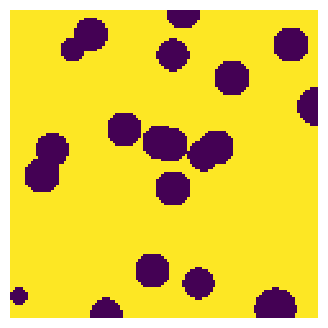

In [2]:
np.random.seed(0)
shape = [120, 120, 50]
dist = sp.stats.norm(loc=7, scale=5)
im = ps.generators.polydisperse_spheres(shape=shape,
                                        porosity=0.7,
                                        dist=dist,
                                        r_min=7)
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
ax.axis(False);

## Computing the tortuosity

In [3]:
results = ps.simulations.tortuosity_fd(im=im, axis=1)
print(results)

[22:02:56] WARNING  Found non-percolating regions, were filled to percolate                              ]8;id=746697;file://c:\Anaconda\Lib\site-packages\porespy\simulations\_dns.py\_dns.py]8;;\:]8;id=279056;file://c:\Anaconda\Lib\site-packages\porespy\simulations\_dns.py#74\74]8;;\

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Results of tortuosity_fd generated at Sat Dec  7 22:03:04 2024
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
im                        Array of size (120, 120, 50)
tortuosity                1.3423339404809018
formation_factor          2.0748071391689207
original_porosity         0.6470041666666667
effective_porosity        0.6469680555555556
concentration             Array of size (120, 120, 50)
sys                       (<465817x465817 sparse matrix of type '<class 'numpy.float64'>'
	with 3064157 stored elements in COOrdinate format>, array([5.69688096, 5.69688096, 5.69688096, ..., 0.        , 0.        ,
       0.        ]))
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


## Extract the network using snow2 algorithm

In [4]:
snow = ps.networks.snow2(im, boundary_width=0, parallelization=None)
regions = snow.regions
net = snow.network

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/107 [00:00<?, ?it/s]

### Computing the diffusive size factor by AI and assigning it to the network

In [5]:
try:
    import tensorflow as tf
except ImportError:
    !pip install tensorflow

try:
    import sklearn
except ImportError:
    !pip install scikit-learn

import os

if not os.path.exists("sf-model-lib"):
    !git clone https://github.com/PMEAL/sf-model-lib

In [6]:
import subprocess
import os
import numpy as np
import porespy as ps
import h5py  # if there was error importing, please install the h5py package
import importlib
import warnings
import openpnm as op
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import time
import tensorflow as tf
ps.visualization.set_mpl_style()
warnings.filterwarnings("ignore")

In [7]:
try:
    import tensorflow as tf
except ImportError:
    !pip install tensorflow

try:
    import sklearn
except ImportError:
    !pip install scikit-learn

import os

if not os.path.exists("sf-model-lib"):
    !git clone https://github.com/PMEAL/sf-model-lib


import importlib
h5tools = importlib.import_module("sf-model-lib.h5tools")
DIR_WEIGHTS = "sf-model-lib/diffusion"
fname_in = [f"{DIR_WEIGHTS}/model_weights_part{j}.h5" for j in [0, 1]]
h5tools.combine(fname_in, fname_out=f"{DIR_WEIGHTS}/model_weights.h5")

path_AI = "./sf-model-lib/diffusion"
path_train = os.path.join(path_AI, 'g_train_original.hdf5')
path_weights = os.path.join(path_AI, 'model_weights.h5')
g_train = h5py.File(path_train, 'r')['g_train'][()]


from tensorflow.keras.optimizers import Adam

# Temporary patch for create_model to avoid modifying source file
def patched_create_model():
    from porespy.networks._size_factors import _resnet3d  # Adjust if needed for your model
    model = _resnet3d()
    model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4), metrics=['mse'])
    return model

# Use the patched function
path = "./sf-model-lib/diffusion"
path_train = os.path.join(path, 'g_train_original.hdf5')
path_weights = os.path.join(path, 'model_weights.h5')
g_train = h5py.File(path_train, 'r')['g_train'][()]
#model = ps.networks.create_model()
model = patched_create_model()
model.load_weights(path_weights)

""" 
np.random.seed(17)
shape = [120, 120, 120]
dist = sp.stats.norm(loc=7, scale=5)
im = ps.generators.polydisperse_spheres(shape=shape,
                                        porosity=0.7,
                                        dist=dist,
                                        r_min=7)
results = ps.filters.snow_partitioning(im=im.astype(bool))
regions = results['regions']
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
ax.imshow(regions[:, :, 20], origin='lower', interpolation='none')
ax.axis(False);
"""
conns = ps.networks.find_conns(regions)
size_factors = ps.networks.diffusive_size_factor_AI(regions,
                                                    model=model,
                                                    g_train=g_train,
                                                    throat_conns=conns)

22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step


[22:04:39] WARNING  From                                                                      ]8;id=690009;file://c:\Anaconda\Lib\site-packages\tensorflow\python\util\module_wrapper.py\module_wrapper.py]8;;\:]8;id=565345;file://c:\Anaconda\Lib\site-packages\tensorflow\python\util\module_wrapper.py#149\149]8;;\
                    c:\Anaconda\Lib\site-packages\keras\src\backend\common\global_state.py:82                      
                    : The name tf.reset_default_graph is deprecated. Please use                                    
                    tf.compat.v1.reset_default_graph instead.                                                      
                                                                                                                   

## Compute diffusive size factor from images 

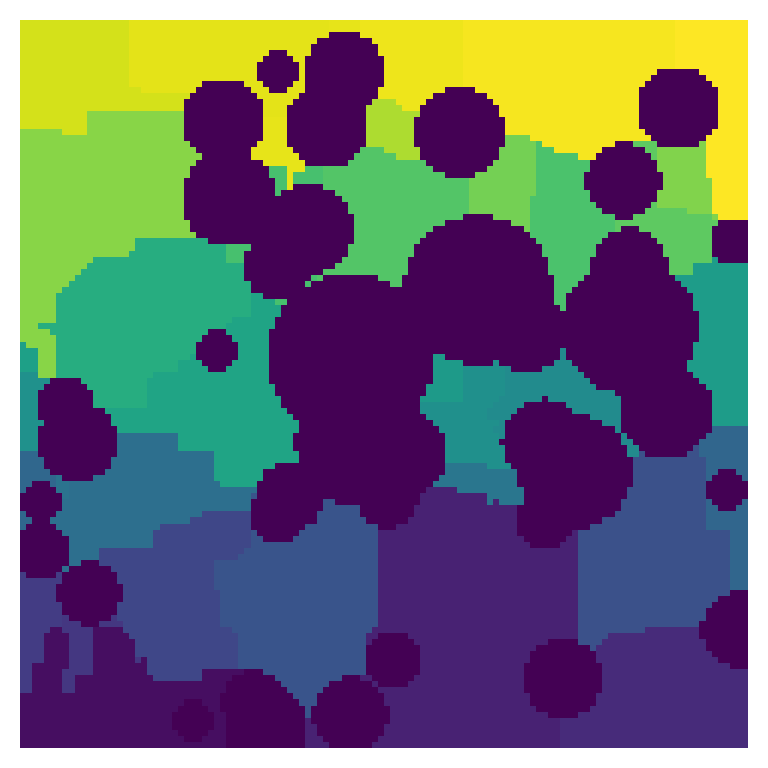

47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step
[ 0.6080618   0.65791208  0.55162547  2.32123524  3.20673144  0.7659536
  3.09369992  0.87398273  3.08424532  0.77352449  0.77331246  1.050683
  0.62767331  3.49900827  2.95300014  2.2924656   3.45041221  2.50630121
  0.70971464  1.85890276 12.67526644  6.0020114  11.67042732  5.05832145
  4.52112132  5.15291272  1.09382438  4.51365975  0.9097242   2.97333616
  1.01118483  0.56498788  5.80484409  1.76739067  9.44015372  0.94709374
  0.92416456  5.74106794  1.8198854  11.28422365 11.05276653  8.26355186
 12.75021887  5.73114351  0.7449993   1.00136251  5.62941294  4.68756567
  3.75388706  1.99655576  2.29719013  3.52553119  5.11066121  3.47062111
  0.86309556  4.54276875  5.84654473  1.59009337  4.00785208  1.10297372
  1.5084703   1.39347065  1.2539767   9.27116767  6.8961938   7.66759411
  0.65249085  5.95060039  8.04021791  5.64084455  6.99307823  3.17303809
  2.94642942  1.14231018  2.85725485  1.17726198  3.54859643  4.14781261
  9.33770968  5

In [8]:
import os
import importlib
import h5py
import tensorflow as tf
import porespy as ps
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Define the function
def compute_diffusive_size_factor_from_image(shape=[120, 120, 120], porosity=0.7, dist_mean=7, dist_scale=5, r_min=7):
    # Step 1: Install and Import Required Libraries
    try:
        import tensorflow as tf
    except ImportError:
        os.system('pip install tensorflow')

    try:
        import sklearn
    except ImportError:
        os.system('pip install scikit-learn')

    if not os.path.exists("sf-model-lib"):
        os.system('git clone https://github.com/PMEAL/sf-model-lib')

    # Step 2: Prepare the Model Weights
    h5tools = importlib.import_module("sf-model-lib.h5tools")
    DIR_WEIGHTS = "sf-model-lib/diffusion"
    fname_in = [f"{DIR_WEIGHTS}/model_weights_part{j}.h5" for j in [0, 1]]
    h5tools.combine(fname_in, fname_out=f"{DIR_WEIGHTS}/model_weights.h5")

    # Step 3: Load AI Model and Weights
    path_AI = "./sf-model-lib/diffusion"
    path_train = os.path.join(path_AI, 'g_train_original.hdf5')
    path_weights = os.path.join(path_AI, 'model_weights.h5')
    g_train = h5py.File(path_train, 'r')['g_train'][()]

    def patched_create_model():
        from porespy.networks._size_factors import _resnet3d
        model = _resnet3d()
        model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4), metrics=['mse'])
        return model

    model = patched_create_model()
    model.load_weights(path_weights)

    # Step 4: Generate Image Using PoreSpy
    np.random.seed(17)
    dist = sp.stats.norm(loc=dist_mean, scale=dist_scale)
    im = ps.generators.polydisperse_spheres(shape=shape, porosity=porosity, dist=dist, r_min=r_min)
    
    # Step 5: Apply SNOW Partitioning Filter
    results = ps.filters.snow_partitioning(im=im.astype(bool))
    regions = results['regions']
    
    # Optional: Plot the Generated Regions
    fig, ax = plt.subplots(1, 1, figsize=[4, 4])
    ax.imshow(regions[:, :, shape[2] // 6], origin='lower', interpolation='none')
    ax.axis(False)
    plt.show()

    # Step 6: Find Connections and Compute Size Factors
    conns = ps.networks.find_conns(regions)
    size_factors = ps.networks.diffusive_size_factor_AI(regions, model=model, g_train=g_train, throat_conns=conns)

    return size_factors

# Example usage
size_factors = compute_diffusive_size_factor_from_image()
print(size_factors)


## Compute Diffsuive size factor from network

In [9]:
import os
import importlib
import h5py
import tensorflow as tf
import porespy as ps
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam


# Define the function
def compute_diffusive_size_factor_from_image(im):
    # Step 1: Install and Import Required Libraries
    try:
        import tensorflow as tf
    except ImportError:
        os.system('pip install tensorflow')

    try:
        import sklearn
    except ImportError:
        os.system('pip install scikit-learn')

    if not os.path.exists("sf-model-lib"):
        os.system('git clone https://github.com/PMEAL/sf-model-lib')

    # Step 2: Prepare the Model Weights
    h5tools = importlib.import_module("sf-model-lib.h5tools")
    DIR_WEIGHTS = "sf-model-lib/diffusion"
    fname_in = [f"{DIR_WEIGHTS}/model_weights_part{j}.h5" for j in [0, 1]]
    h5tools.combine(fname_in, fname_out=f"{DIR_WEIGHTS}/model_weights.h5")

    # Step 3: Load AI Model and Weights
    path_AI = "./sf-model-lib/diffusion"
    path_train = os.path.join(path_AI, 'g_train_original.hdf5')
    path_weights = os.path.join(path_AI, 'model_weights.h5')
    g_train = h5py.File(path_train, 'r')['g_train'][()]

    def patched_create_model():
        from porespy.networks._size_factors import _resnet3d
        model = _resnet3d()
        model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4), metrics=['mse'])
        return model

    model = patched_create_model()
    model.load_weights(path_weights)

    # Step 4: Generate Image Using PoreSpy
    np.random.seed(17)
    dist = sp.stats.norm(loc=dist_mean, scale=dist_scale)
    im = ps.generators.polydisperse_spheres(shape=shape, porosity=porosity, dist=dist, r_min=r_min)
    
    # Step 5: Apply SNOW Partitioning Filter
    results = ps.filters.snow_partitioning(im=im.astype(bool))
    regions = results['regions']
    
    # Step 6: Find Connections and Compute Size Factors
    conns = ps.networks.find_conns(regions)
    size_factors = ps.networks.diffusive_size_factor_AI(regions, model=model, g_train=g_train, throat_conns=conns)

    return size_factors

# Example usage

 # Step 4: Generate Image Using PoreSpy
np.random.seed(0)
shape=[120, 120, 120]
porosity=0.7
dist_mean=7
dist_scale=5
r_min=7
dist = sp.stats.norm(loc=dist_mean, scale=dist_scale)
im = ps.generators.polydisperse_spheres(shape=shape, porosity=porosity, dist=dist, r_min=r_min)

size_factors = compute_diffusive_size_factor_from_image(im)
print(size_factors)


47/47 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step
[ 0.6080618   0.65791208  0.55162547  2.32123524  3.20673144  0.7659536
  3.09369992  0.87398273  3.08424532  0.77352449  0.77331246  1.050683
  0.62767331  3.49900827  2.95300014  2.2924656   3.45041221  2.50630121
  0.70971464  1.85890276 12.67526644  6.0020114  11.67042732  5.05832145
  4.52112132  5.15291272  1.09382438  4.51365975  0.9097242   2.97333616
  1.01118483  0.56498788  5.80484409  1.76739067  9.44015372  0.94709374
  0.92416456  5.74106794  1.8198854  11.28422365 11.05276653  8.26355186
 12.75021887  5.73114351  0.7449993   1.00136251  5.62941294  4.68756567
  3.75388706  1.99655576  2.29719013  3.52553119  5.11066121  3.47062111
  0.86309556  4.54276875  5.84654473  1.59009337  4.00785208  1.10297372
  1.5084703   1.39347065  1.2539767   9.27116767  6.8961938   7.66759411
  0.65249085  5.95060039  8.04021791  5.64084455  6.99307823  3.17303809
  2.94642942  1.14231018  2.85725485  1.17726198  3.54859643  4.14781261
  9.33770968  5

In [10]:
path = 'rock_sample_Leopard' # this is the path folder for reading/saving the image data for this example
name = 'image_Leopard.raw' # this is the name of the saved file
if not os.path.isdir(path):
    os.makedirs(path)

file_name = path+'/'+name
url = 'https://www.digitalrocksportal.org/projects/317/images/223481/download/'

def download_image(filename, url):
    download_command = f'wget {url} -O {filename}'
    try:
        subprocess.run(download_command.split(' '))
    except FileNotFoundError:
        raise InterruptedError(f'wget was not found. Please make sure it is installed on your system.')
    return

download_image(file_name, url)

InterruptedError: wget was not found. Please make sure it is installed on your system.

### These are the code for plotting 3D relative permeability and relative diffusivity of simulations

In [11]:
import os
def plot_relative_permeability(results, network, im, save_dir):
    # Create the specified directory if it does not exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Relative Permeability Plot
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    
    # Define style elements
    line_styles = {'x': 'solid', 'y': 'dashed', 'z': 'dotted'}
    line_width = 1.5
    marker_styles = {'x': 'o', 'y': 's', 'z': '^'}
    
    for direction in results['saturation'].keys():
        # Smooth the data
        saturation = results['saturation'][direction]
        kr_air = results['kr_air'][direction]
        kr_water = results['kr_water'][direction]

        # Interpolation
        interp_func_air = interp1d(saturation, kr_air, kind='linear')
        interp_func_water = interp1d(saturation, kr_water, kind='linear')
        smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
        smooth_kr_air = interp_func_air(smooth_saturation)
        smooth_kr_water = interp_func_water(smooth_saturation)

        # Plotting both air and water with different styles for each direction
        ax.plot(smooth_saturation, smooth_kr_air, label=f'Kr_air ({direction})', 
                linestyle=line_styles[direction], linewidth=line_width, marker=marker_styles[direction], markersize=4)
        ax.plot(smooth_saturation, smooth_kr_water, label=f'Kr_water ({direction})', 
                linestyle=line_styles[direction], linewidth=line_width, marker=marker_styles[direction], markersize=4)

    # Setting plot parameters
    ax.set_xlabel('Water Saturation [-]', fontsize=12, labelpad=10)
    ax.set_ylabel('Relative Permeability (Kr)', fontsize=12, labelpad=10)
    ax.set_title('Relative Permeability in x, y, and z Directions', fontsize=14, pad=15)
    ax.legend(fontsize=10, loc='best', title='Phase & Direction', title_fontsize=10)
    
    # Axis and tick customization
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove unnecessary borders for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save the plot
    plot_path = os.path.join(save_dir, "relative_permeability_plot.png")
    plt.tight_layout()
    plt.savefig(plot_path, format='png')
    plt.close(fig)
    print(f"Relative permeability plot saved at {plot_path}")

    # Network Visualization
    # Microstructure visualization
    fig, ax = plt.subplots(1, 1, figsize=[4, 4], dpi=300)
    ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
    ax.axis(False)
    microstructure_path = os.path.join(save_dir, "microstructure.png")
    plt.savefig(microstructure_path, format='png')
    plt.close(fig)
    print(f"Microstructure image saved at {microstructure_path}")

    # Network connectivity visualization
    fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
    ax = op.visualization.plot_connections(network, ax=ax)
    ax = op.visualization.plot_coordinates(network, ax=ax)
    network_plot_path = os.path.join(save_dir, "network_plot.png")
    plt.savefig(network_plot_path, format='png')
    plt.close(fig)
    print(f"Network plot saved at {network_plot_path}")

    # Save network information
    network_info_path = os.path.join(save_dir, "network_info.txt")
    with open(network_info_path, 'w') as f:
        f.write(str(network))
    print(f"Network information saved at {network_info_path}")
    
    salome_file = save_dir + 'network_to_salome'
    ## Export to Salome
    op.io.network_to_salome(pn,filename=str(salome_file))

    # Save the network to salome
    
def plot_relative_diffusivity(results, save_dir):
    # Create the specified directory if it does not exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Relative Permeability Plot
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    
    # Define style elements
    line_styles = {'x': 'solid', 'y': 'dashed', 'z': 'dotted'}
    line_width = 1.5
    marker_styles = {'x': 'o', 'y': 's', 'z': '^'}
    
    for direction in results['saturation'].keys():
        # Smooth the data
        saturation = results['saturation'][direction]
        Dr_air = results['Dr_air'][direction]
        Dr_water = results['Dr_water'][direction]

        # Interpolation
        interp_func_air = interp1d(saturation, Dr_air, kind='linear')
        interp_func_water = interp1d(saturation,Dr_water, kind='linear')
        smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
        smooth_Dr_air = interp_func_air(smooth_saturation)
        smooth_Dr_water = interp_func_water(smooth_saturation)

        # Plotting both air and water with different styles for each direction
        ax.plot(smooth_saturation, smooth_Dr_air, label=f'Dr_air ({direction})', 
                linestyle=line_styles[direction], linewidth=line_width, marker=marker_styles[direction], markersize=4)
        ax.plot(smooth_saturation, smooth_Dr_water, label=f'Dr_water ({direction})', 
                linestyle=line_styles[direction], linewidth=line_width, marker=marker_styles[direction], markersize=4)

    # Setting plot parameters
    ax.set_xlabel('Water Saturation [-]', fontsize=12, labelpad=10)
    ax.set_ylabel('Relative Diffusivity (Dr)', fontsize=12, labelpad=10)
    ax.set_title('Relative Diffusivity in x, y, and z Directions', fontsize=14, pad=15)
    ax.legend(fontsize=10, loc='best', title='Phase & Direction', title_fontsize=10)
    
    # Axis and tick customization
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove unnecessary borders for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save the plot
    plot_path = os.path.join(save_dir, "relative_diffusivity_plot.png")
    plt.tight_layout()
    plt.savefig(plot_path, format='png')
    plt.close(fig)
    print(f"Relative diffusivity plot saved at {plot_path}")
    plt.show()


## Simulation from artificial generated image
From the generated images, the pores connectivity and coordinates were extracted , and used to rebuild the network for simulations with openPNM

## Relative permeability

Preparing images and DNS calculations:   0%|          | 0/4088 [00:00<?, ?it/s]

PyPardisoError: The Pardiso solver failed with error code -2. See Pardiso documentation for details.

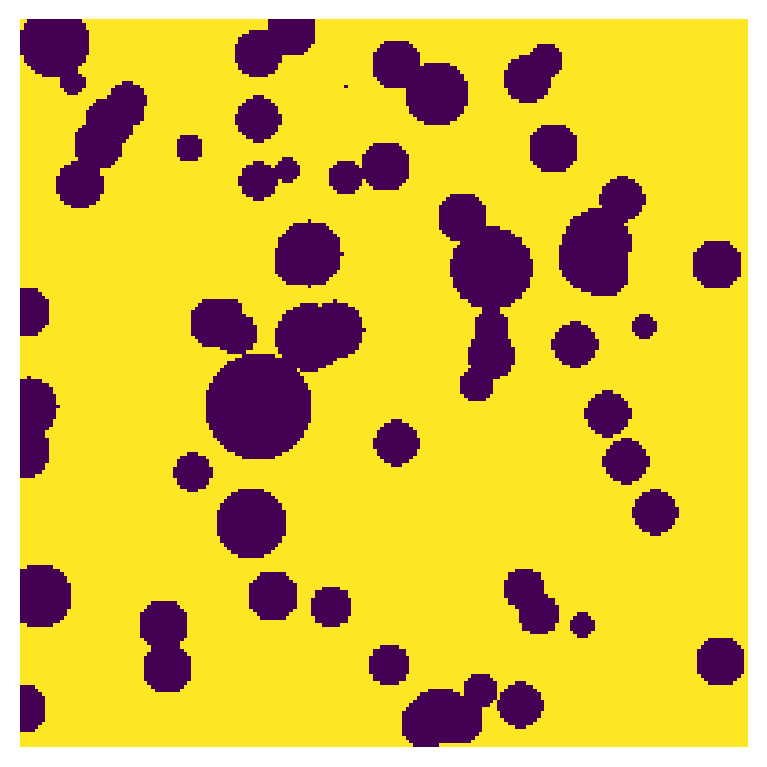

In [13]:
#pn['throat.volume'] = pn['throat.cross_sectional_area']*pn['throat.total_length']
import os
import h5py
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import openpnm as op
import warnings
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

## Generate microstructure

np.random.seed(0)
shape = [200, 200, 200]
voxel_size = 1
dist = sp.stats.norm(loc=7, scale=5)
im = ps.generators.polydisperse_spheres(shape=shape,
                                        porosity=0.7,
                                        dist=dist,
                                        r_min=7)
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
ax.axis(False);

## Extract the nework using snow algorithm
### Create a pore network model from the image
snow = ps.networks.snow2(im, boundary_width=[3,3,3], parallelization=None, voxel_size = voxel_size)
regions = snow.regions
net = snow.network
conns = net['throat.conns']
g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
net['throat.diffusive_size_factor'] = g_FD

## uncomment to Compute diffusive size factor if needed and assign it to the network
""" 
conns = net['throat.conns']
g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
net['throat.diffusive_size_factor_AI'] = g_FD
"""

#pn1 = op.io.network_from_porespy(net)
## Create networ from porespy segmented image

pn = op.io.network_from_porespy(net)
mods = op.models.collections.geometry.spheres_and_cylinders
#pprint(mods)
pn.add_model_collection(mods)
pn['pore.diameter'] = pn['pore.equivalent_diameter']
pn['throat.diameter'] = pn['throat.inscribed_diameter']
pn['throat.spacing'] = pn['throat.total_length']

pn.regenerate_models()
print(pn)

pn.add_model(propname='throat.hydraulic_size_factors',
             model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
pn.add_model(propname='throat.diffusive_size_factors',
             model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
  
pn['throat.diffusive_size_factor'] = g_FD
pn.regenerate_models()

## Check network health
h = op.utils.check_network_health(pn)
print(h)

## remove disconnected pores from the network
op.topotools.trim(network=pn, pores=h['disconnected_pores'])
h = op.utils.check_network_health(pn)
print(h)

"""
## Creating network using pore coordinates and  connectivity 
coords = pn1['pore.coords']
conns = pn1['throat.conns']
pn = op.network.Network(coords=coords, conns=conns)
print(pn)
from pprint import pprint
mods = op.models.collections.geometry.spheres_and_cylinders
#pprint(mods)
pn.add_model_collection(mods)
pn.regenerate_models()
""" 

print(pn)
ax = op.visualization.plot_connections(pn)
ax = op.visualization.plot_coordinates(pn, ax=ax)


#pn.regenerate_models()
pn.add_model(propname='pore.cluster_number',
             model=op.models.network.cluster_number)
pn.add_model(propname='pore.cluster_size',
             model=op.models.network.cluster_size)
print(pn)
print('pore diameter cluster=',pn['pore.cluster_number'])
print("==================================================")
print('pore cluster size=', pn['pore.cluster_size'])

###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
""" 
Ps = pn['pore.cluster_size'] < 100
op.topotools.trim(network=pn, pores=Ps)
ax = op.visualization.plot_tutorial(pn, font_size=8)
"""
###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

k = 1.38e-23  # Boltzmann constant in J/K
T = 300  # Temperature in K
a = 1.52e-10  # Radius of water molecule in meters

# Define viscosity and surface tension models
def viscosity_arrhenius(water, mu_0=1.002e-3, Ea=5000, R=8.314):
    T = water['pore.temperature']
    mu = mu_0 * np.exp(Ea / (R * T))
    return mu

def surface_tension_model(water, sigma_0=0.0756, Tc=647.096, n=1.256):
    T = water['pore.temperature']
    sigma = sigma_0 * (1 - T / Tc) ** n
    return sigma


def compute_diffusivity(diameter):
    """
    Computes the diffusivity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of diffusivities.
    """
    diameter = diameter*1e10  #the pore network unit is in meter , so we need to convert it to Amstrong
    return (k * T) / (6 * np.pi * a * diameter)

def compute_viscosity(diameter):
    """
    Computes the viscosity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of viscosities.
    """
    diffusivity = compute_diffusivity(diameter)
    return (k * T) / (6 * np.pi * diffusivity * a)

air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 180.0
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()

water = op.phase.Water(network=pn,name='water')
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water.regenerate_models()

#pn = ps.networks.label_boundaries(net,labels=[['left', 'right'],[ 'bottom','top']], tol=1e-9)
# Compute diffusivity and viscosity
pore_diffusivity = compute_diffusivity(pn['pore.diameter'])
pore_viscosity = compute_viscosity(pn['pore.diameter'])
throat_diffusivity = compute_diffusivity(pn['throat.diameter'])
throat_viscosity = compute_viscosity(pn['throat.diameter'])

# Assign diffusivity and viscosity
pn['pore.diffusivity'] = pore_diffusivity
pn['pore.viscosity'] = pore_viscosity
pn['throat.diffusivity'] = throat_diffusivity
pn['throat.viscosity'] = throat_viscosity

air['throat.diffusivity'] = throat_diffusivity # 1e-9 #pn['throat.diffusivity']
water['throat.diffusivity'] = throat_diffusivity #pn['throat.diffusivity']

# Assign viscosity using the Arrhenius model
water.add_model(propname='pore.viscosity', model=viscosity_arrhenius)

# Add the custom surface tension model to the water phase
water.add_model(propname='pore.surface_tension', model=surface_tension_model)

# Add the diffusive conductance model
air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

air.regenerate_models()
water.regenerate_models()

model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
Finlets_init = pn.pores('zmin')
Finlets=([Finlets_init[x] for x in range(0, len(Finlets_init), 2)])
ip.set_inlet_BC(pores=Finlets)
ip.run()

def sat_occ_update(network, nwp, wp, ip, i):
    r"""
        Calculates the saturation of each phase using the invasion
        sequence from either invasion percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        ip : IP
            invasion percolation (ran before calling this function)
        i: int
            The invasion_sequence limit for masking pores/throats that
            have already been invaded within this limit range. The
            saturation is found by adding the volume of pores and thorats
            that meet this sequence limit divided by the bulk volume.
    """
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val

flow_in = pn.pores('zmin')
flow_out = pn.pores('zmax')

model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

Snwp_num=100

# Boundary conditions for each direction
directions = {
    'x': ('xmin', 'xmax'),
    'y': ('ymin', 'ymax'),
    'z': ('zmin', 'zmax')
}

# Dictionary to store simulation results for each direction
results = {'saturation': {}, 'kr_air': {}, 'kr_water': {}}

# Run simulations for each direction
for direction, (inlet, outlet) in directions.items():
    
    ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
    Finlets_init = pn.pores(inlet)
    Finlets=([Finlets_init[x] for x in range(0, len(Finlets_init), 2)])
    ip.set_inlet_BC(pores=Finlets)
    ip.run()
    max_seq = np.max([np.max(ip['pore.invasion_sequence']),
            np.max(ip['throat.invasion_sequence'])])
    start = max_seq//Snwp_num
    stop = max_seq
    step = max_seq//Snwp_num
    Snwparr = []
    relperm_nwp = []
    relperm_wp = []

    for i in range(start, stop, step):
        air.regenerate_models();
        water.regenerate_models();
        sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
        Snwparr.append(sat)
        Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
        Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
        Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
        Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
        relperm_nwp.append(Rate_enwp/Rate_abs_nwp)
        relperm_wp.append(Rate_ewp/Rate_abs_wp)
        
               # Convert results to numpy arrays
        results['saturation'][direction] = 1 - np.array(Snwparr)
        results['kr_air'][direction] = np.array(relperm_nwp).flatten()
        results['kr_water'][direction] = np.array(relperm_wp).flatten()

        saturation = 1-np.asarray(Snwparr)
        kr_air = np.array(relperm_nwp).flatten()
        kr_water = np.array(relperm_wp).flatten()
        # Define interpolating functions
        interp_func_air = interp1d(saturation, kr_air, kind='linear')
        interp_func_water = interp1d(saturation, kr_water, kind='linear')

        # Generate smooth data points
        smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
        smooth_kr_air = interp_func_air(smooth_saturation)
        smooth_kr_water = interp_func_water(smooth_saturation)
        

# Call the plot function
save_dir= 'rock_sample_leopard'
plot_relative_permeability(results,pn, im, save_dir)

### Compute relative permeability for different porosities

In [ ]:
import h5py
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import openpnm as op
import porespy as ps
import warnings
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import os


# Define viscosity and surface tension models
def viscosity_arrhenius(water, mu_0=1.002e-3, Ea=5000, R=8.314):
    T = water['pore.temperature']
    mu = mu_0 * np.exp(Ea / (R * T))
    return mu

def surface_tension_model(water, sigma_0=0.0756, Tc=647.096, n=1.256):
    T = water['pore.temperature']
    sigma = sigma_0 * (1 - T / Tc) ** n
    return sigma


def compute_diffusivity(diameter):
    """
    Computes the diffusivity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of diffusivities.
    """
    diameter = diameter*1e10  #the pore network unit is in meter , so we need to convert it to Amstrong
    return (k * T) / (6 * np.pi * a * diameter)

def compute_viscosity(diameter):
    """
    Computes the viscosity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of viscosities.
    """
    diffusivity = compute_diffusivity(diameter)
    return (k * T) / (6 * np.pi * diffusivity * a)


def sat_occ_update(network, nwp, wp, ip, i):
    r"""
        Calculates the saturation of each phase using the invasion
        sequence from either invasion percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        ip : IP
            invasion percolation (ran before calling this function)
        i: int
            The invasion_sequence limit for masking pores/throats that
            have already been invaded within this limit range. The
            saturation is found by adding the volume of pores and thorats
            that meet this sequence limit divided by the bulk volume.
    """
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val

# Define the porosity values you want to simulate
porosity_values = [0.3,0.4,0.5, 0.6, 0.7, 0.8]

# Initialize results dictionary for storing results for each porosity
simulation_results = {}

# Loop through each porosity value
for porosity in porosity_values:
    print(f"Simulating for porosity: {porosity}")
    
    ## Generate microstructure
    np.random.seed(0)
    shape = [200, 200, 200]
    dist = stats.norm(loc=7, scale=5)
    im = ps.generators.polydisperse_spheres(shape=shape,
                                            porosity=porosity,
                                            dist=dist,
                                            r_min=7)
    fig, ax = plt.subplots(1, 1, figsize=[4, 4])
    ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
    ax.axis(False)

    ## Extract the network using snow algorithm
    snow = ps.networks.snow2(im, boundary_width=[3,3,3], parallelization=None, voxel_size=1e-6)
    regions = snow.regions
    net = snow.network
    conns = net['throat.conns']
    g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
    net['throat.diffusive_size_factor'] = g_FD

    # Create network from porespy segmented image
    pn = op.io.network_from_porespy(net)
    mods = op.models.collections.geometry.spheres_and_cylinders
    pn.add_model_collection(mods)
    pn['pore.diameter'] = pn['pore.equivalent_diameter']
    pn['throat.diameter'] = pn['throat.inscribed_diameter']
    pn['throat.spacing'] = pn['throat.total_length']
    pn.regenerate_models()
    
    pn.add_model(propname='throat.hydraulic_size_factors',
                 model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
    pn.add_model(propname='throat.diffusive_size_factors',
                 model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
    pn['throat.diffusive_size_factor'] = g_FD
    pn.regenerate_models()

    ## Check network health
    h = op.utils.check_network_health(pn)
    print(h)

    ## Remove disconnected pores from the network
    op.topotools.trim(network=pn, pores=h['disconnected_pores'])
    h = op.utils.check_network_health(pn)
    print(h)

    ## Phases and properties
    
    air = op.phase.Air(network=pn,name='air')
    air['pore.surface_tension'] = 0.072
    air['pore.contact_angle'] = 180.0
    air.add_model_collection(op.models.collections.phase.air)
    air.add_model_collection(op.models.collections.physics.basic)
    air.regenerate_models()
    water = op.phase.Water(network=pn,name='water')
    water.add_model_collection(op.models.collections.phase.water)
    water.add_model_collection(op.models.collections.physics.basic)
    water.regenerate_models()
    #pn = ps.networks.label_boundaries(net,labels=[['left', 'right'],[ 'bottom','top']], tol=1e-9)
    # Compute diffusivity and viscosity
    pore_diffusivity = compute_diffusivity(pn['pore.diameter'])
    pore_viscosity = compute_viscosity(pn['pore.diameter'])
    throat_diffusivity = compute_diffusivity(pn['throat.diameter'])
    throat_viscosity = compute_viscosity(pn['throat.diameter'])
    # Assign diffusivity and viscosity
    pn['pore.diffusivity'] = pore_diffusivity
    pn['pore.viscosity'] = pore_viscosity
    pn['throat.diffusivity'] = throat_diffusivity
    pn['throat.viscosity'] = throat_viscosity

    air['throat.diffusivity'] = throat_diffusivity # 1e-9 #pn['throat.diffusivity']
    water['throat.diffusivity'] = throat_diffusivity #pn['throat.diffusivity']

    # Assign viscosity using the Arrhenius model
    water.add_model(propname='pore.viscosity', model=viscosity_arrhenius)

    # Add the custom surface tension model to the water phase
    water.add_model(propname='pore.surface_tension', model=surface_tension_model)

    # Add the diffusive conductance model
    air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
    water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

    air.regenerate_models()
    water.regenerate_models()

    # Boundary conditions for each direction
    directions = {
        'x': ('xmin', 'xmax'),
        'y': ('ymin', 'ymax'),
        'z': ('zmin', 'zmax')
    }

    # Dictionary to store simulation results for each direction
    results = {'saturation': {}, 'kr_air': {}, 'kr_water': {}}

    # Run simulations for each direction
    for direction, (inlet, outlet) in directions.items():
        ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
        Finlets_init = pn.pores(inlet)
        Finlets = [Finlets_init[x] for x in range(0, len(Finlets_init), 2)]
        ip.set_inlet_BC(pores=Finlets)
        ip.run()
        max_seq = np.max([np.max(ip['pore.invasion_sequence']),
                          np.max(ip['throat.invasion_sequence'])])
        start = max_seq // 100
        stop = max_seq
        step = max_seq // 100
        Snwparr = []
        relperm_nwp = []
        relperm_wp = []

        for i in range(start, stop, step):
            air.regenerate_models()
            water.regenerate_models()
            sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
            Snwparr.append(sat)
            Rate_abs_nwp = Rate_calc(pn, air, pn.pores(inlet), pn.pores(outlet), conductance='throat.hydraulic_conductance')
            Rate_abs_wp = Rate_calc(pn, water, pn.pores(inlet), pn.pores(outlet), conductance='throat.hydraulic_conductance')
            Rate_enwp = Rate_calc(pn, air, pn.pores(inlet), pn.pores(outlet), conductance='throat.conduit_hydraulic_conductance')
            Rate_ewp = Rate_calc(pn, water, pn.pores(inlet), pn.pores(outlet), conductance='throat.conduit_hydraulic_conductance')
            relperm_nwp.append(Rate_enwp / Rate_abs_nwp)
            relperm_wp.append(Rate_ewp / Rate_abs_wp)

            # Convert results to numpy arrays
            results['saturation'][direction] = 1 - np.array(Snwparr)
            results['kr_air'][direction] = np.array(relperm_nwp).flatten()
            results['kr_water'][direction] = np.array(relperm_wp).flatten()

    # Store results for each porosity
    simulation_results[porosity] = results

    # Plot results or save as needed
    save_dir = f'rock_sample_porosity_{porosity}'
    plot_relative_permeability(results, pn, im, save_dir)

# Plot results for all porosities in one figure
def plot_relative_permeability_all(simulation_results):
    # Relative Permeability Plot
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    
    # Define style elements
    line_width = 1.5
    marker_styles = ['o', 's', '^', 'D', 'v']
    line_styles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 5, 1, 5))]

    for idx, (porosity, results) in enumerate(simulation_results.items()):
        for direction in results['saturation'].keys():
            # Smooth the data
            saturation = results['saturation'][direction]
            kr_air = results['kr_air'][direction]
            kr_water = results['kr_water'][direction]
            # Interpolation
            interp_func_air = interp1d(saturation, kr_air, kind='linear')
            interp_func_water = interp1d(saturation, kr_water, kind='linear')
            smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
            smooth_kr_air = interp_func_air(smooth_saturation)
            smooth_kr_water = interp_func_water(smooth_saturation)

            # Plotting both air and water with different styles for each direction
            ax.plot(smooth_saturation, smooth_kr_air, label=f'Kr_air (Porosity {porosity}, {direction})', 
                    linestyle=line_styles[idx % len(line_styles)], linewidth=line_width, marker=marker_styles[idx % len(marker_styles)], markersize=4)
            ax.plot(smooth_saturation, smooth_kr_water, label=f'Kr_water (Porosity {porosity}, {direction})', 
                    linestyle=line_styles[idx % len(line_styles)], linewidth=line_width, marker=marker_styles[idx % len(marker_styles)], markersize=4)

    # Setting plot parameters
    ax.set_xlabel('Water Saturation [-]', fontsize=12, labelpad=10)
    ax.set_ylabel('Relative Permeability (Kr)', fontsize=12, labelpad=10)
    ax.set_title('Relative Permeability for Different Porosities in x, y, and z Directions', fontsize=14, pad=15)
    ax.legend(fontsize=10, loc='best', title='Phase, Porosity & Direction', title_fontsize=10)
    
    # Axis and tick customization
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove unnecessary borders for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save the plot
    save_dir = "artificial_image/"
    
    plot_path =  save_dir+ "relative_permeability_all_porosity.png"
    plt.tight_layout()
    plt.savefig(plot_path, format='png')
    plt.close(fig)
    print(f"Relative permeability plot for all porosities saved at {plot_path}")

# Call the function to plot all results
plot_relative_permeability_all(simulation_results)

### Compute relative permeabilities for different pore size distributions

<>:216: SyntaxWarning: invalid escape sequence '\c'
<>:217: SyntaxWarning: invalid escape sequence '\h'
<>:219: SyntaxWarning: invalid escape sequence '\h'
<>:220: SyntaxWarning: invalid escape sequence '\e'
<>:216: SyntaxWarning: invalid escape sequence '\c'
<>:217: SyntaxWarning: invalid escape sequence '\h'
<>:219: SyntaxWarning: invalid escape sequence '\h'
<>:220: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Ce pc\AppData\Local\Temp\ipykernel_33508\1567018591.py:216: SyntaxWarning: invalid escape sequence '\c'
  latex_file.write("\begin{table}[h!]\n\centering\n\begin{tabular}{|l|l|l|l|l|l|}\n\hline\n")
C:\Users\Ce pc\AppData\Local\Temp\ipykernel_33508\1567018591.py:217: SyntaxWarning: invalid escape sequence '\h'
  latex_file.write(" & ".join(header) + " \\\n\hline\n")
C:\Users\Ce pc\AppData\Local\Temp\ipykernel_33508\1567018591.py:219: SyntaxWarning: invalid escape sequence '\h'
  latex_file.write(" & ".join(row) + " \\\n\hline\n")
C:\Users\Ce pc\AppData\Local\Temp\ipyker

Tortuosity results saved in simulation_results_2024-12-02_23-41-28\tortuosity_results.csv and simulation_results_2024-12-02_23-41-28\tortuosity_results.tex
Simulating for distribution: normal, porosity: 0.4


0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/90 [00:00<?, ?it/s]

Preparing images and DNS calculations:   0%|          | 0/151 [00:00<?, ?it/s]

c:\Anaconda\Lib\site-packages\porespy\networks\_size_factors.py:197: RuntimeWarning: Mean of empty slice.
  c2_avr = algs['pore.concentration'][meds['pore.region2']].mean()


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats                   []
bidirectional_throats               []
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats                   []
bidirectional_throats               []
―――――――――――――――――――――――――――――――――――――――――――――――――――――

[23:41:46] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=47238;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=914191;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[23:41:47] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=674601;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=360899;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=831464;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=288804;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

C:\Users\Ce pc\AppData\Local\Temp\ipykernel_33508\1567018591.py:216: SyntaxWarning: invalid escape sequence '\c'
  latex_file.write("\begin{table}[h!]\n\centering\n\begin{tabular}{|l|l|l|l|l|l|}\n\hline\n")
C:\Users\Ce pc\AppData\Local\Temp\ipykernel_33508\1567018591.py:217: SyntaxWarning: invalid escape sequence '\h'
  latex_file.write(" & ".join(header) + " \\\n\hline\n")
C:\Users\Ce pc\AppData\Local\Temp\ipykernel_33508\1567018591.py:219: SyntaxWarning: invalid escape sequence '\h'
  latex_file.write(" & ".join(row) + " \\\n\hline\n")
C:\Users\Ce pc\AppData\Local\Temp\ipykernel_33508\1567018591.py:220: SyntaxWarning: invalid escape sequence '\e'
  latex_file.write("\end{tabular}\n\caption{Tortuosity results for different pore size distributions and porosities.}\n\label{tab:tortuosity_results}\n\end{table}")


KeyError: 'throat.conduit_hydraulic_conductance'

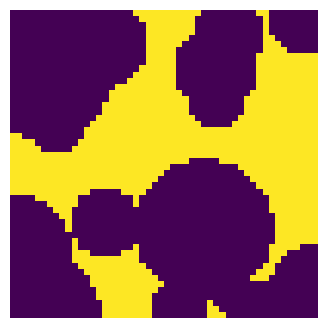

In [5]:
import h5py
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import openpnm as op
import porespy as ps
import warnings
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import os
from mayavi import mlab
import csv
from datetime import datetime

#Create a directory name containing date including day, hour, minute, second
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_directory = f"simulation_results_{current_time}"
os.makedirs(results_directory, exist_ok=True)

#Define the porosity values and distribution types you want to simulate
porosity_values = [0.4] #[0.3, 0.4, 0.5, 0.6, 0.7,0.8]
distribution_types = {
    'normal': lambda: stats.norm(loc=7, scale=5),
    'weibull': lambda: stats.weibull_min(c=2, scale=7),
    'lognormal': lambda: stats.lognorm(s=0.5, scale=np.exp(7))
}

# Initialize results dictionary for storing results for each porosity and distribution
simulation_results = {}

# File paths for storing results
csv_file_path = os.path.join(results_directory, "tortuosity_results.csv")
latex_file_path = os.path.join(results_directory, "tortuosity_results.tex")
final_csv_path = os.path.join(results_directory, "combined_results_for_AI.csv")

# Write headers to CSV file if it doesn't exist
if not os.path.exists(csv_file_path):
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Distribution", "Porosity", "Tortuosity", "Formation Factor", "Original Porosity", "Effective Porosity"])

# Write headers to the final combined CSV file
if not os.path.exists(final_csv_path):
    with open(final_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Distribution", "Porosity", "Direction", "Saturation", "Kr_air", "Kr_water", "Tortuosity", "Formation Factor", "Original Porosity", "Effective Porosity"])

print(f"Tortuosity results saved in {csv_file_path} and {latex_file_path}")

# Loop through each distribution type
for dist_name, dist_func in distribution_types.items():
    simulation_results[dist_name] = {}
    # Loop through each porosity value
    for porosity in porosity_values:
        print(f"Simulating for distribution: {dist_name}, porosity: {porosity}")
        ## Generate microstructure
        np.random.seed(0)
        shape = [50, 50, 50]
        dist = dist_func()
        im = ps.generators.polydisperse_spheres(shape=shape,
                                                porosity=porosity,
                                                dist=dist,
                                                r_min=7)
        ### Visualization of generated image
        fig, ax = plt.subplots(1, 1, figsize=[4, 4])
        ax.imshow(im[:, :, 1], origin='lower', interpolation='none')
        ax.axis(False)
        """ 
        # Mayavi visualization for a scientific paper
        mlab.figure(size=(800, 800), bgcolor=(1, 1, 1))
        src = mlab.pipeline.scalar_field(im)
        mlab.pipeline.iso_surface(src, contours=[im.mean()], opacity=0.3, color=(0.1, 0.5, 0.8))
        mlab.pipeline.iso_surface(src, contours=[im.max() - 0.1], color=(0.8, 0.1, 0.1))
        mlab.axes(src, color=(0, 0, 0), xlabel='X', ylabel='Y', zlabel='Z', line_width=1.5)
        mlab.outline(color=(0, 0, 0), line_width=1.5)
        mayavi_plot_path = os.path.join(results_directory, f'mayavi_visualization_{dist_name}_porosity_{porosity}.png')
        mlab.savefig(mayavi_plot_path)
        mlab.close()
        print(f"3D visualization saved at {mayavi_plot_path}")
        """
        ## Extract the network using snow algorithm
        snow = ps.networks.snow2(im, boundary_width=[3,3,3], parallelization=None, voxel_size=1e-6)
        regions = snow.regions
        net = snow.network
        conns = net['throat.conns']
        g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
        net['throat.diffusive_size_factor'] = g_FD

        # Create network from porespy segmented image
        pn = op.io.network_from_porespy(net)
        mods = op.models.collections.geometry.spheres_and_cylinders
        pn.add_model_collection(mods)
        pn['pore.diameter'] = pn['pore.equivalent_diameter']
        pn['throat.diameter'] = pn['throat.inscribed_diameter']
        pn['throat.spacing'] = pn['throat.total_length']
        pn.regenerate_models()
        
        pn.add_model(propname='throat.hydraulic_size_factors',
                     model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
        pn.add_model(propname='throat.diffusive_size_factors',
                     model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
        pn['throat.diffusive_size_factor'] = g_FD
        pn.regenerate_models()

        ## Check network health
        h = op.utils.check_network_health(pn)
        print(h)

        ## Remove disconnected pores from the network
        op.topotools.trim(network=pn, pores=h['disconnected_pores'])
        h = op.utils.check_network_health(pn)
        print(h)

        ## Phases and properties
        air = op.phase.Air(network=pn, name='air')
        air['pore.surface_tension'] = 0.072
        air['pore.contact_angle'] = 180.0
        air.add_model_collection(op.models.collections.phase.air)
        air.add_model_collection(op.models.collections.physics.basic)
        air.regenerate_models()
        
        water = op.phase.Water(network=pn, name='water')
        water.add_model_collection(op.models.collections.phase.water)
        water.add_model_collection(op.models.collections.physics.basic)
        water.regenerate_models()

        # Boundary conditions for each direction
        directions = {
            'x': ('xmin', 'xmax'),
            'y': ('ymin', 'ymax'),
            'z': ('zmin', 'zmax')
        }

        # Dictionary to store simulation results for each direction
        results = {'saturation': {}, 'kr_air': {}, 'kr_water': {}}

        # Run simulations for each direction
        for direction, (inlet, outlet) in directions.items():
            ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
            Finlets_init = pn.pores(inlet)
            Finlets = [Finlets_init[x] for x in range(0, len(Finlets_init), 2)]
            ip.set_inlet_BC(pores=Finlets)
            ip.run()
            max_seq = np.max([np.max(ip['pore.invasion_sequence']),
                              np.max(ip['throat.invasion_sequence'])])
            start = max_seq // 100
            stop = max_seq
            step = max_seq // 100
            Snwparr = []
            relperm_nwp = []
            relperm_wp = []

            for i in range(start, stop, step):
                air.regenerate_models()
                water.regenerate_models()
                sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
                Snwparr.append(sat)
                Rate_abs_nwp = Rate_calc(pn, air, pn.pores(inlet), pn.pores(outlet), conductance='throat.hydraulic_conductance')
                Rate_abs_wp = Rate_calc(pn, water, pn.pores(inlet), pn.pores(outlet), conductance='throat.hydraulic_conductance')
                Rate_enwp = Rate_calc(pn, air, pn.pores(inlet), pn.pores(outlet), conductance='throat.conduit_hydraulic_conductance')
                Rate_ewp = Rate_calc(pn, water, pn.pores(inlet), pn.pores(outlet), conductance='throat.conduit_hydraulic_conductance')
                relperm_nwp.append(Rate_enwp / Rate_abs_nwp)
                relperm_wp.append(Rate_ewp / Rate_abs_wp)

                # Convert results to numpy arrays
                results['saturation'][direction] = 1 - np.array(Snwparr)
                results['kr_air'][direction] = np.array(relperm_nwp).flatten()
                results['kr_water'][direction] = np.array(relperm_wp).flatten()

        # Store results for each porosity and distribution
        simulation_results[dist_name][porosity] = results

        # Plot results or save as needed
        # Plot results or save as needed
        save_dir = os.path.join(results_directory, f'rock_sample_{dist_name}_porosity_{porosity}')
        os.makedirs(save_dir, exist_ok=True)
        plot_relative_permeability(results, pn, im, save_dir)
        
        # Compute tortuosity
        tortuosity_results = ps.simulations.tortuosity_fd(im=im, axis=1)
        print(tortuosity_results)
        tortuosity = tortuosity_results['tortuosity']
        formation_factor = tortuosity_results['formation_factor']
        original_porosity = tortuosity_results['original_porosity']
        effective_porosity = tortuosity_results['effective_porosity']

        # Append results to CSV file
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([dist_name, porosity, tortuosity, formation_factor, original_porosity, effective_porosity])

        # Save combined results for AI training
        with open(final_csv_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            for direction in results['saturation'].keys():
                saturation = results['saturation'][direction]
                kr_air = results['kr_air'][direction]
                kr_water = results['kr_water'][direction]
                for sat, kr_a, kr_w in zip(saturation, kr_air, kr_water):
                    writer.writerow([dist_name, porosity, direction, sat, kr_a, kr_w, tortuosity, formation_factor, original_porosity, effective_porosity])


# Write results to LaTeX table format
with open(csv_file_path, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file)
    header = next(csv_reader)
    rows = list(csv_reader)

    with open(latex_file_path, mode='w') as latex_file:
        latex_file.write("\begin{table}[h!]\n\centering\n\begin{tabular}{|l|l|l|l|l|l|}\n\hline\n")
        latex_file.write(" & ".join(header) + " \\\n\hline\n")
        for row in rows:
            latex_file.write(" & ".join(row) + " \\\n\hline\n")
        latex_file.write("\end{tabular}\n\caption{Tortuosity results for different pore size distributions and porosities.}\n\label{tab:tortuosity_results}\n\end{table}")
    print(f"Tortuosity results saved in {csv_file_path} and {latex_file_path}")

# Plot results for all porosities and distributions in one figure
def plot_relative_permeability_all_porosity_pore_dist(simulation_results):
    # Relative Permeability Plot
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    
    # Define style elements
    line_width = 1.5
    marker_styles = ['o', 's', '^', 'D', 'v']
    line_styles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 5, 1, 5))]

    for dist_idx, (dist_name, porosity_results) in enumerate(simulation_results.items()):
        for porosity_idx, (porosity, results) in enumerate(porosity_results.items()):
            for direction in results['saturation'].keys():
                # Smooth the data
                saturation = results['saturation'][direction]
                kr_air = results['kr_air'][direction]
                kr_water = results['kr_water'][direction]

                # Interpolation
                interp_func_air = interp1d(saturation, kr_air, kind='linear')
                interp_func_water = interp1d(saturation, kr_water, kind='linear')
                smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
                smooth_kr_air = interp_func_air(smooth_saturation)
                smooth_kr_water = interp_func_water(smooth_saturation)

                # Plotting both air and water with different styles for each direction
                ax.plot(smooth_saturation, smooth_kr_air, label=f'Kr_air ({dist_name}, Porosity {porosity}, {direction})', 
                        linestyle=line_styles[(dist_idx + porosity_idx) % len(line_styles)], linewidth=line_width, marker=marker_styles[(dist_idx + porosity_idx) % len(marker_styles)], markersize=4)
                ax.plot(smooth_saturation, smooth_kr_water, label=f'Kr_water ({dist_name}, Porosity {porosity}, {direction})', 
                        linestyle=line_styles[(dist_idx + porosity_idx) % len(line_styles)], linewidth=line_width, marker=marker_styles[(dist_idx + porosity_idx) % len(marker_styles)], markersize=4)

    # Setting plot parameters
    ax.set_xlabel('Water Saturation [-]', fontsize=12, labelpad=10)
    ax.set_ylabel('Relative Permeability (Kr)', fontsize=12, labelpad=10)
    ax.set_title('Relative Permeability for Different Porosities and Distributions in x, y, and z Directions', fontsize=14, pad=15)
    ax.legend(fontsize=10, loc='best', title='Phase, Distribution, Porosity & Direction', title_fontsize=10)
    
    # Axis and tick customization
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove unnecessary borders for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save the plot
    plot_path = os.path.join(results_directory, "relative_permeability_all_porosity_distributions.png")
    plt.tight_layout()
    plt.savefig(plot_path, format='png')
    plt.close(fig)
    print(f"Relative permeability plot for all porosities and distributions saved at {plot_path}")

# Call the function to plot all results
plot_relative_permeability_all_porosity_pore_dist(simulation_results)

### Pore shape factor impact on relative humidity

## Pore shape and anisotropy factor 




In [ ]:
import h5py
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import openpnm as op
import porespy as ps
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.pyplot as plt
import warnings
from scipy.interpolate import interp1d
import os
import csv
from datetime import datetime
from mayavi import mlab


k = 1.38e-23  # Boltzmann constant in J/K
T = 300  # Temperature in K
a = 1.52e-10  # Radius of water molecule in meters

# Define viscosity and surface tension models
def viscosity_arrhenius(water, mu_0=1.002e-3, Ea=5000, R=8.314):
    T = water['pore.temperature']
    mu = mu_0 * np.exp(Ea / (R * T))
    return mu

def surface_tension_model(water, sigma_0=0.0756, Tc=647.096, n=1.256):
    T = water['pore.temperature']
    sigma = sigma_0 * (1 - T / Tc) ** n
    return sigma


def compute_diffusivity(diameter):
    """
    Computes the diffusivity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of diffusivities.
    """
    diameter = diameter*1e10  #the pore network unit is in meter , so we need to convert it to Amstrong
    return (k * T) / (6 * np.pi * a * diameter)

def compute_viscosity(diameter):
    """
    Computes the viscosity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of viscosities.
    """
    diffusivity = compute_diffusivity(diameter)
    return (k * T) / (6 * np.pi * diffusivity * a)

def sat_occ_update(network, nwp, wp, ip, i):
    r"""
        Calculates the saturation of each phase using the invasion
        sequence from either invasion percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        ip : IP
            invasion percolation (ran before calling this function)
        i: int
            The invasion_sequence limit for masking pores/throats that
            have already been invaded within this limit range. The
            saturation is found by adding the volume of pores and thorats
            that meet this sequence limit divided by the bulk volume.
    """
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val

# Define the blobiness values for sensitivity analysis
#blobiness_values = [[1, 1, 1], [1, 2, 3], [2, 2, 2], [2, 3, 4], [3, 3, 3], [3, 4, 5], [4, 4, 4], [4, 5, 6], [5, 5, 5], [5, 6, 7]]

blobiness_values = [[1, 1, 1], [1, 2, 3], [2, 2, 2]]

print("======================== Directory initialization ======================================")
print("======================== Provide study name =========================================================")

studyname="study_pore_shape_and_anisotropy_impact"
# Create a directory name containing date including day, hour, minute, second

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

results_directory = f"{studyname}_simulation_results_{current_time}"

os.makedirs(results_directory, exist_ok=True)

# Initialize results dictionary for storing results for each blobiness value
simulation_results = {}

# File paths for storing results
csv_file_path = os.path.join(results_directory, "tortuosity_results.csv")
final_csv_path = os.path.join(results_directory, "combined_results_for_AI.csv")

# Write headers to CSV file if it doesn't exist
if not os.path.exists(csv_file_path):
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Blobiness", "Tortuosity", "Formation Factor", "Original Porosity", "Effective Porosity"])

# Write headers to the final combined CSV file
if not os.path.exists(final_csv_path):
    with open(final_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Blobiness", "Direction", "Saturation", "Kr_air", "Kr_water", "Tortuosity", "Formation Factor", "Original Porosity", "Effective Porosity"])

# Loop through each blobiness value
for blobiness in blobiness_values:
    print(f"Simulating for blobiness: {blobiness}")
    
    ## Generate microstructure
    np.random.seed(0)
    shape = [200, 200, 200]
    porosity = 0.5
    im = ps.generators.blobs(shape=shape, porosity=porosity, blobiness=blobiness)
    
    ## Extract the network using snow algorithm
    snow = ps.networks.snow2(im, boundary_width=[3, 3, 3], parallelization=None, voxel_size=1e-6)
    regions = snow.regions
    net = snow.network
    conns = net['throat.conns']
    
    #g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
    #net['throat.diffusive_size_factor'] = g_FD

    # Create network from porespy segmented image
    pn = op.io.network_from_porespy(net)

    mods = op.models.collections.geometry.cubes_and_cuboids
    pn.add_model_collection(mods)
    
    pn['pore.diameter'] = pn['pore.equivalent_diameter']
    pn['throat.diameter'] = pn['throat.inscribed_diameter']
    pn['throat.spacing'] = pn['throat.total_length']
    
    #pn.regenerate_models()
    
    pn.add_model(propname='throat.hydraulic_size_factors',
                 model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
    pn.add_model(propname='throat.diffusive_size_factors',
                 model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
    #pn['throat.diffusive_size_factor'] = g_FD
    pn.regenerate_models()

    ## Check network health
    h = op.utils.check_network_health(pn)
    print(h)

    ## Remove disconnected pores from the network
    op.topotools.trim(network=pn, pores=h['disconnected_pores'])
    h = op.utils.check_network_health(pn)
    print(h)

    """ 
    ## Phases and properties 
    air = op.phase.Air(network=pn,name='air')
    air['pore.surface_tension'] = 0.072
    air['pore.contact_angle'] = 180.0
    air.add_model_collection(op.models.collections.phase.air)
    air.add_model_collection(op.models.collections.physics.basic)
    air.regenerate_models()
    water = op.phase.Water(network=pn,name='water')
    water.add_model_collection(op.models.collections.phase.water)
    water.add_model_collection(op.models.collections.physics.basic)
    water.regenerate_models()
    #pn = ps.networks.label_boundaries(net,labels=[['left', 'right'],[ 'bottom','top']], tol=1e-9)
    # Compute diffusivity and viscosity
    pore_diffusivity = compute_diffusivity(pn['pore.diameter'])
    pore_viscosity = compute_viscosity(pn['pore.diameter'])
    throat_diffusivity = compute_diffusivity(pn['throat.diameter'])
    throat_viscosity = compute_viscosity(pn['throat.diameter'])
    # Assign diffusivity and viscosity
    pn['pore.diffusivity'] = pore_diffusivity
    pn['pore.viscosity'] = pore_viscosity
    pn['throat.diffusivity'] = throat_diffusivity
    pn['throat.viscosity'] = throat_viscosity

    air['throat.diffusivity'] = throat_diffusivity # 1e-9 #pn['throat.diffusivity']
    water['throat.diffusivity'] = throat_diffusivity #pn['throat.diffusivity']

    # Assign viscosity using the Arrhenius model
    water.add_model(propname='pore.viscosity', model=viscosity_arrhenius)

    # Add the custom surface tension model to the water phase
    water.add_model(propname='pore.surface_tension', model=surface_tension_model)

    # Add the diffusive conductance model
    air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
    water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

    air.regenerate_models()
    water.regenerate_models()
    """ 
     # Create phases
    air = op.phase.Air(network=pn, name='air')
    air['pore.surface_tension'] = 0.072
    air['pore.contact_angle'] = 140.0
    air.add_model_collection(op.models.collections.phase.air)
    air.add_model_collection(op.models.collections.physics.basic)
    air.regenerate_models()

    water = op.phase.Water(network=pn, name='water')
    water.add_model_collection(op.models.collections.phase.water)
    water.add_model_collection(op.models.collections.physics.basic)

    # Define throat diffusivity for both air and water phases
    air['throat.diffusivity'] = 1e-9  # Example value for air
    water['throat.diffusivity'] = 1e-9  # Example value for water

    # Add the diffusive conductance model
    air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
    water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

    model_mp_cond = op.models.physics.multiphase.conduit_conductance
    air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
                throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
    water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
                throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
    
    air.regenerate_models()
    water.regenerate_models()

    # Boundary conditions for each direction
      # Boundary conditions for each direction
    directions = {
        'x': ('xmin', 'xmax'),
        'y': ('ymin', 'ymax'),
        'z': ('zmin', 'zmax')
    }

    # Dictionary to store simulation results for each direction
    results = {'saturation': {}, 'kr_air': {}, 'kr_water': {}}

    # Run simulations for each direction
    for direction, (inlet, outlet) in directions.items():
        ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
        Finlets_init = pn.pores(inlet)
        Finlets = [Finlets_init[x] for x in range(0, len(Finlets_init), 2)]
        ip.set_inlet_BC(pores=Finlets)
        ip.run()
        max_seq = np.max([np.max(ip['pore.invasion_sequence']),
                          np.max(ip['throat.invasion_sequence'])])
        start = max_seq // 100
        stop = max_seq
        step = max_seq // 100
        Snwparr = []
        relperm_nwp = []
        relperm_wp = []

        for i in range(start, stop, step):
            air.regenerate_models()
            water.regenerate_models()
            sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
            Snwparr.append(sat)
            Rate_abs_nwp = Rate_calc(pn, air, pn.pores(inlet), pn.pores(outlet), conductance='throat.hydraulic_conductance')
            Rate_abs_wp = Rate_calc(pn, water, pn.pores(inlet), pn.pores(outlet), conductance='throat.hydraulic_conductance')
            Rate_enwp = Rate_calc(pn, air, pn.pores(inlet), pn.pores(outlet), conductance='throat.conduit_hydraulic_conductance')
            Rate_ewp = Rate_calc(pn, water, pn.pores(inlet), pn.pores(outlet), conductance='throat.conduit_hydraulic_conductance')
            relperm_nwp.append(Rate_enwp / Rate_abs_nwp)
            relperm_wp.append(Rate_ewp / Rate_abs_wp)

            # Convert results to numpy arrays
            results['saturation'][direction] = 1 - np.array(Snwparr)
            results['kr_air'][direction] = np.array(relperm_nwp).flatten()
            results['kr_water'][direction] = np.array(relperm_wp).flatten()

    # Store results for each blobiness value
    simulation_results[str(blobiness)] = results

    # Compute tortuosity
    tortuosity_results = ps.simulations.tortuosity_fd(im=im, axis=1)
    print(tortuosity_results)
    tortuosity = tortuosity_results['tortuosity']
    formation_factor = tortuosity_results['formation_factor']
    original_porosity = tortuosity_results['original_porosity']
    effective_porosity = tortuosity_results['effective_porosity']

    # Append results to CSV file
    with open(csv_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([blobiness, tortuosity, formation_factor, original_porosity, effective_porosity])

    # Save combined results for AI training
    with open(final_csv_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        for direction in results['saturation'].keys():
            saturation = results['saturation'][direction]
            kr_air = results['kr_air'][direction]
            kr_water = results['kr_water'][direction]
            for sat, kr_a, kr_w in zip(saturation, kr_air, kr_water):
                writer.writerow([blobiness, direction, sat, kr_a, kr_w, tortuosity, formation_factor, original_porosity, effective_porosity])

print(f"Tortuosity results saved in {csv_file_path}")
print(f"Combined results for AI saved in {final_csv_path}")

# Plot results for all blobiness values in one figure
def plot_relative_permeability_all_blobiness(simulation_results,results_directory ):
    # Relative Permeability Plot
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    
    # Define style elements
    line_width = 1.5
    marker_styles = ['o', 's', '^', 'D', 'v']
    line_styles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 5, 1, 5))]

    for blob_idx, (blobiness, results) in enumerate(simulation_results.items()):
        for direction in results['saturation'].keys():
            # Smooth the data
            saturation = results['saturation'][direction]
            kr_air = results['kr_air'][direction]
            kr_water = results['kr_water'][direction]

            # Interpolation
            interp_func_air = interp1d(saturation, kr_air, kind='linear')
            interp_func_water = interp1d(saturation, kr_water, kind='linear')
            smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
            smooth_kr_air = interp_func_air(smooth_saturation)
            smooth_kr_water = interp_func_water(smooth_saturation)

            # Plotting both air and water with different styles for each direction
            ax.plot(smooth_saturation, smooth_kr_air, label=f'Kr_air (Blobiness {blobiness}, {direction})', 
                    linestyle=line_styles[blob_idx % len(line_styles)], linewidth=line_width, marker=marker_styles[blob_idx % len(marker_styles)], markersize=4)
            ax.plot(smooth_saturation, smooth_kr_water, label=f'Kr_water (Blobiness {blobiness}, {direction})', 
                    linestyle=line_styles[blob_idx % len(line_styles)], linewidth=line_width, marker=marker_styles[blob_idx % len(marker_styles)], markersize=4)

    # Setting plot parameters
    ax.set_xlabel('Water Saturation [-]', fontsize=12, labelpad=10)
    ax.set_ylabel('Relative Permeability (Kr)', fontsize=12, labelpad=10)
    ax.set_title('Relative Permeability for Different Blobiness Values in x and y Directions', fontsize=14, pad=15)
    ax.legend(fontsize=10, loc='best', title='Phase, Blobiness & Direction', title_fontsize=10)
    
    # Axis and tick customization
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove unnecessary borders for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save the plot
    plot_path = os.path.join(results_directory, "relative_permeability_all_blobiness.png")
    plt.tight_layout()
    plt.savefig(plot_path, format='png')
    plt.close(fig)
    print(f"Relative permeability plot for all blobiness values saved at {plot_path}")

# Call the function to plot all results
plot_relative_permeability_all_blobiness(simulation_results,results_directory )


======================== Directory initialization ======================================
======================== Provide study name =========================================================
Simulating for blobiness: [1, 1, 1]
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  [14, 860]
duplicate_throats                   []
bidirectional_throats               []
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats

[03:02:26] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=383465;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=751528;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=87594;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=255256;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=417675;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=319976;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=183066;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=30405;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

[03:07:45] WARNING  Found non-percolating regions, were filled to percolate                              ]8;id=407414;file://c:\Anaconda\Lib\site-packages\porespy\simulations\_dns.py\_dns.py]8;;\:]8;id=730145;file://c:\Anaconda\Lib\site-packages\porespy\simulations\_dns.py#74\74]8;;\

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Results of tortuosity_fd generated at Sun Nov  3 03:09:48 2024
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
im                        Array of size (200, 200, 200)
tortuosity                1.9650098701393235
formation_factor          3.958007802955294
original_porosity         0.4964785
effective_porosity        0.496464375
concentration             Array of size (200, 200, 200)
sys                       (<3971715x3971715 sparse matrix of type '<class 'numpy.float64'>'
	with 26344937 stored elements in COOrdinate format>, array([5.69819083, 5.69819083, 5.69819083, ..., 0.        , 0.        ,
       0.        ]))
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Simulating for blobiness: [1, 2, 3]
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
―――――――――――――――――――――――――――――

[03:12:20] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=522303;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=691788;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=383170;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=396717;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

[03:12:21] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=116432;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=266044;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=271533;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=260775;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

[04:55:36] WARNING  Found non-percolating regions, were filled to percolate                              ]8;id=467902;file://c:\Anaconda\Lib\site-packages\porespy\simulations\_dns.py\_dns.py]8;;\:]8;id=133038;file://c:\Anaconda\Lib\site-packages\porespy\simulations\_dns.py#74\74]8;;\

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Results of tortuosity_fd generated at Sun Nov  3 04:57:39 2024
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
im                        Array of size (200, 200, 200)
tortuosity                2.265171403241418
formation_factor          4.532611378477765
original_porosity         0.499914
effective_porosity        0.49974975
concentration             Array of size (200, 200, 200)
sys                       (<3997998x3997998 sparse matrix of type '<class 'numpy.float64'>'
	with 25498718 stored elements in COOrdinate format>, array([5.43551898, 5.43551898, 5.43551898, ..., 0.        , 0.        ,
       0.        ]))
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Simulating for blobiness: [2, 2, 2]
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――

[05:01:58] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=50741;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=478731;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=283091;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=331474;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

[05:01:59] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=929358;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=11265;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=965020;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=399840;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

## More nicely organized code for pore shape and anisotropy factor

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm
from sklearn.mixture import GaussianMixture
from scipy.signal import find_peaks
import scipy.stats as stats
import os
import logging
import csv
import openpnm as op
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from datetime import datetime
import porespy as ps

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")


k = 1.38e-23  # Boltzmann constant in J/K
T = 300  # Temperature in K
a = 1.52e-10  # Radius of water molecule in meters

# Define the function
def compute_diffusive_size_factor_from_image(regions, conns):
    # Step 1: Install and Import Required Libraries
    try:
        import tensorflow as tf
    except ImportError:
        os.system('pip install tensorflow')

    try:
        import sklearn
    except ImportError:
        os.system('pip install scikit-learn')

    if not os.path.exists("sf-model-lib"):
        os.system('git clone https://github.com/PMEAL/sf-model-lib')

    # Step 2: Prepare the Model Weights
    h5tools = importlib.import_module("sf-model-lib.h5tools")
    DIR_WEIGHTS = "sf-model-lib/diffusion"
    fname_in = [f"{DIR_WEIGHTS}/model_weights_part{j}.h5" for j in [0, 1]]
    h5tools.combine(fname_in, fname_out=f"{DIR_WEIGHTS}/model_weights.h5")

    # Step 3: Load AI Model and Weights
    path_AI = "./sf-model-lib/diffusion"
    path_train = os.path.join(path_AI, 'g_train_original.hdf5')
    path_weights = os.path.join(path_AI, 'model_weights.h5')
    g_train = h5py.File(path_train, 'r')['g_train'][()]

    def patched_create_model():
        from porespy.networks._size_factors import _resnet3d
        model = _resnet3d()
        model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4), metrics=['mse'])
        return model

    model = patched_create_model()
    model.load_weights(path_weights)
    """
    # Step 5: Apply SNOW Partitioning Filter
    results = ps.filters.snow_partitioning(im=im.astype(bool))
    regions = results['regions']
    # Step 6: Find Connections and Compute Size Factors
    conns = ps.networks.find_conns(regions)
    """
    size_factors = ps.networks.diffusive_size_factor_AI(regions, model=model, g_train=g_train, throat_conns=conns)

    return size_factors

# Define viscosity and surface tension models
def viscosity_arrhenius(water, mu_0=1.002e-3, Ea=5000, R=8.314):
    T = water['pore.temperature']
    mu = mu_0 * np.exp(Ea / (R * T))
    return mu

def surface_tension_model(water, sigma_0=0.0756, Tc=647.096, n=1.256):
    T = water['pore.temperature']
    sigma = sigma_0 * (1 - T / Tc) ** n
    return sigma


def compute_diffusivity(diameter):
    """
    Computes the diffusivity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of diffusivities.
    """
    diameter = diameter*1e10  #the pore network unit is in meter , so we need to convert it to Amstrong
    return (k * T) / (6 * np.pi * a * diameter)

def compute_viscosity(diameter):
    """
    Computes the viscosity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of viscosities.
    """
    diffusivity = compute_diffusivity(diameter)
    return (k * T) / (6 * np.pi * diffusivity * a)

def sat_occ_update(network, nwp, wp, ip, i):
    r"""
        Calculates the saturation of each phase using the invasion
        sequence from either invasion percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        ip : IP
            invasion percolation (ran before calling this function)
        i: int
            The invasion_sequence limit for masking pores/throats that
            have already been invaded within this limit range. The
            saturation is found by adding the volume of pores and thorats
            that meet this sequence limit divided by the bulk volume.
    """
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val

# Function to initialize the directory and files for storing the results of the study
def initialize_study_directory(studyname, study_variable):
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    results_directory = f"{studyname}_simulation_results_{current_time}"
    os.makedirs(results_directory, exist_ok=True)
    # File paths for storing results
    tortuosity_csv_path = os.path.join(results_directory, "tortuosity_results.csv")
    relperm_csv_path = os.path.join(results_directory, "relative_permeability_results.csv")
    final_csv_path = os.path.join(results_directory, "combined_results_for_AI.csv")

    # Write headers to CSV files if they don't exist
    if not os.path.exists(tortuosity_csv_path):
        with open(tortuosity_csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([study_variable, "Tortuosity", "Formation Factor", "Original Porosity", "Effective Porosity"])

    if not os.path.exists(relperm_csv_path):
        with open(relperm_csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([study_variable, "Direction", "Saturation", "Kr_air", "Kr_water"])

    if not os.path.exists(final_csv_path):
        with open(final_csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([study_variable, "Direction", "Saturation", "Kr_air", "Kr_water", "Tortuosity", "Formation Factor", "Original Porosity", "Effective Porosity"])

    return results_directory, tortuosity_csv_path, relperm_csv_path, final_csv_path


# Function to create a pore network ready for simulation from images
def create_pore_network_from_image(blobiness_values, shape=[200, 200, 200], porosity=0.5):
    
    pore_networks = {}
    
    for blobiness in blobiness_values:
        print(f"Simulating for blobiness: {blobiness}")

        # Generate microstructure
        np.random.seed(0)
        im = ps.generators.blobs(shape=shape, porosity=porosity, blobiness=blobiness)

        # Extract the network using snow algorithm
        snow = ps.networks.snow2(im, boundary_width=[3, 3, 3], parallelization=None, voxel_size=1e-6)
        regions = snow.regions
        net = snow.network
        conns = net['throat.conns']

        # Create network from porespy segmented image
        pn = op.io.network_from_porespy(net)
        mods = op.models.collections.geometry.spheres_and_cylinders
        pn.add_model_collection(mods)
        pn['pore.diameter'] = pn['pore.equivalent_diameter']
        pn['throat.diameter'] = pn['throat.inscribed_diameter']
        pn['throat.spacing'] = pn['throat.total_length']
        pn.regenerate_models()

        pn.add_model(propname='throat.hydraulic_size_factors',
                     model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
        pn.add_model(propname='throat.diffusive_size_factors',
                     model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
        
        
        g_FD = compute_diffusive_size_factor_from_image(regions, conns)
        pn['throat.diffusive_size_factor'] = g_FD
        pn.regenerate_models()

        # Check network health
        h = op.utils.check_network_health(pn)
        print(h)

        # Remove disconnected pores from the network
        op.topotools.trim(network=pn, pores=h['disconnected_pores'])
        h = op.utils.check_network_health(pn)
        print(h)
        pore_networks['blobiness'] = pn
        
    return pore_networks

    
#Function to perform the relative permeability and tortuosity simulation
def perform_simulation(pn, blobiness, directions, csv_file_path, final_csv_path):
   
    """ 
    pn['pore.volume'] = pn['pore.volume']
    f = op.models.geometry.throat_length.spheres_and_cylinders
    pn.add_model(propname='throat.length', model=f)
    f1 = op.models.geometry.pore_volume.sphere
    pn.add_model(propname='pore.volume', model=f1)
    f2 = op.models.geometry.throat_volume.cylinder
    pn.add_model(propname='throat.total_volume', model=f2)
    f3 = op.models.geometry.throat_volume.lens
    pn.add_model(propname='throat.lens_volume', model=f3)
    f4 = op.models.misc.difference
    pn.add_model(propname='throat.volume', model=f4, props=['throat.total_volume', 'throat.lens_volume'])
    """ 
    #Create phases
    air = op.phase.Air(network=pn, name='air')
    air['pore.surface_tension'] = 0.072
    air['pore.contact_angle'] = 140.0
    air.add_model_collection(op.models.collections.phase.air)
    air.add_model_collection(op.models.collections.physics.basic)
    air.regenerate_models()

    water = op.phase.Water(network=pn, name='water')
    water.add_model_collection(op.models.collections.phase.water)
    water.add_model_collection(op.models.collections.physics.basic)
    #Define throat diffusivity for both air and water phases
    air['throat.diffusivity'] = 1e-9  # Example value for air
    water['throat.diffusivity'] = 1e-9  # Example value for water

    # Add the diffusive conductance model
    air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
    water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
    model_mp_cond = op.models.physics.multiphase.conduit_conductance
    air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
                  throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
    water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
                    throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

    air.regenerate_models()
    water.regenerate_models()

    # Dictionary to store simulation results for each direction
    results = {'saturation': {}, 'kr_air': {}, 'kr_water': {}}
    
    # Run simulations for each direction
    for direction, (inlet, outlet) in directions.items():
        ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
        Finlets_init = pn.pores(inlet)
        Finlets = [Finlets_init[x] for x in range(0, len(Finlets_init), 2)]
        ip.set_inlet_BC(pores=Finlets)
        ip.run()
      
        max_seq = np.max([np.max(ip['pore.invasion_sequence']),
                          np.max(ip['throat.invasion_sequence'])])
        start = max_seq // 100
        stop = max_seq
        step = max_seq // 100
        Snwparr = []
        relperm_nwp = []
        relperm_wp = []

        for i in range(start, stop, step):
            air.regenerate_models()
            water.regenerate_models()
            sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
            Snwparr.append(sat)
            Rate_abs_nwp = Rate_calc(pn, air, pn.pores(inlet), pn.pores(outlet), conductance='throat.hydraulic_conductance')
            Rate_abs_wp = Rate_calc(pn, water, pn.pores(inlet), pn.pores(outlet), conductance='throat.hydraulic_conductance')
            Rate_enwp = Rate_calc(pn, air, pn.pores(inlet), pn.pores(outlet), conductance='throat.conduit_hydraulic_conductance')
            Rate_ewp = Rate_calc(pn, water, pn.pores(inlet), pn.pores(outlet), conductance='throat.conduit_hydraulic_conductance')
            relperm_nwp.append(Rate_enwp / Rate_abs_nwp)
            relperm_wp.append(Rate_ewp / Rate_abs_wp)
            # Convert results to numpy arrays
            results['saturation'][direction] = 1 - np.array(Snwparr)
            results['kr_air'][direction] = np.array(relperm_nwp).flatten()
            results['kr_water'][direction] = np.array(relperm_wp).flatten()

    #Extract tortuosity results
    tortuosity_results = ps.simulations.tortuosity_fd(im=im, axis=1)
    print(tortuosity_results)
    tortuosity = tortuosity_results['tortuosity']
    formation_factor = tortuosity_results['formation_factor']
    original_porosity = tortuosity_results['original_porosity']
    effective_porosity = tortuosity_results['effective_porosity']

    # Append results to CSV file
    with open(csv_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([blobiness, tortuosity, formation_factor, original_porosity, effective_porosity])

    # Save combined results for AI training
    with open(final_csv_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        for direction in results['saturation'].keys():
            saturation = results['saturation'][direction]
            kr_air = results['kr_air'][direction]
            kr_water = results['kr_water'][direction]
            for sat, kr_a, kr_w in zip(saturation, kr_air, kr_water):
                writer.writerow([blobiness, direction, sat, kr_a, kr_w, tortuosity, formation_factor, original_porosity, effective_porosity])

    return results

#Plot results for all blobiness values in one figure
def plot_relative_permeability_all_blobiness(simulation_results,results_directory):
    
    #Relative Permeability Plot
    
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    #Define style elements
    line_width = 1.5
    marker_styles = ['o', 's', '^', 'D', 'v']
    line_styles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 5, 1, 5))]
    
    for blob_idx, (blobiness, results) in enumerate(simulation_results.items()):
        for direction in results['saturation'].keys():
            # Smooth the data
            saturation = results['saturation'][direction]
            kr_air = results['kr_air'][direction]
            kr_water = results['kr_water'][direction]
           
            # Interpolation
            interp_func_air = interp1d(saturation, kr_air, kind='linear')
            interp_func_water = interp1d(saturation, kr_water, kind='linear')
            smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
            smooth_kr_air = interp_func_air(smooth_saturation)
            smooth_kr_water = interp_func_water(smooth_saturation)

            # Plotting both air and water with different styles for each direction
            ax.plot(smooth_saturation, smooth_kr_air, label=f'Kr_air (Blobiness {blobiness}, {direction})', 
                    linestyle=line_styles[blob_idx % len(line_styles)], linewidth=line_width, marker=marker_styles[blob_idx % len(marker_styles)], markersize=4)
            ax.plot(smooth_saturation, smooth_kr_water, label=f'Kr_water (Blobiness {blobiness}, {direction})', 
                    linestyle=line_styles[blob_idx % len(line_styles)], linewidth=line_width, marker=marker_styles[blob_idx % len(marker_styles)], markersize=4)

    # Setting plot parameters
    ax.set_xlabel('Water Saturation [-]', fontsize=12, labelpad=10)
    ax.set_ylabel('Relative Permeability (Kr)', fontsize=12, labelpad=10)
    ax.set_title('Relative Permeability for Different Blobiness Values in x and y Directions', fontsize=14, pad=15)
    ax.legend(fontsize=10, loc='best', title='Phase, Blobiness & Direction', title_fontsize=10)
    
    # Axis and tick customization
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove unnecessary borders for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save the plot
    plot_path = os.path.join(results_directory, "relative_permeability_all_blobiness.png")
    plt.tight_layout()
    plt.savefig(plot_path, format='png')
    plt.close(fig)
    print(f"Relative permeability plot for all blobiness values saved at {plot_path}")




In [ ]:

#Example usage
studyname = "study_pore_shape_and_anisotropy_impact"
study_variable = "blobiness"
#blobiness_values = [0.1, 0.3, 0.5, 0.7]
blobiness_values = [[1, 1, 2], [1, 2, 3],[1, 3, 3]]

# Initialize study directory
results_directory, csv_file_path, relperm_csv_path, final_csv_path = initialize_study_directory(studyname, study_variable)

simulations_results = {}

#Create pore networks from images
pore_networks = create_pore_network_from_image(blobiness_values)

# Perform simulations
for blobiness, pn in pore_networks.items():
    print(pn)
    directions = {
        'x': ('xmin', 'xmax'),
        #'y': ('ymin', 'ymax'),
        #'z': ('zmin', 'zmax')
    }
    results = perform_simulation(pn, blobiness, directions, csv_file_path, final_csv_path)
    simulations_results[str(blobiness)] = results

plot_relative_permeability_all_blobiness(simulations_results,results_directory)
print(f"Tortuosity results saved in {csv_file_path}")
print(f"Combined results for AI saved in {final_csv_path}")

Simulating for blobiness: [1, 1, 2]
273/273 ━━━━━━━━━━━━━━━━━━━━ 701s 3s/step
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  [81, 656, 1312, 1383, 1446, 1652, 1819, 1954]
duplicate_throats                   []
bidirectional_throats               []
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_

MemoryError: Unable to allocate 8.34 MiB for an array with shape (206, 206, 206) and data type bool

In [13]:
plot_relative_permeability_all_blobiness(simulations_results,results_directory)
print(f"Tortuosity results saved in {csv_file_path}")
print(f"Combined results for AI saved in {final_csv_path}")

Relative permeability plot for all blobiness values saved at study_pore_shape_and_anisotropy_impact_simulation_results_2024-11-04_18-26-14\relative_permeability_all_blobiness.png
Tortuosity results saved in study_pore_shape_and_anisotropy_impact_simulation_results_2024-11-04_18-26-14\tortuosity_results.csv
Combined results for AI saved in study_pore_shape_and_anisotropy_impact_simulation_results_2024-11-04_18-26-14\combined_results_for_AI.csv


# Compute properties from different pore size distribution: experimental measured and  artificial  pore size distribution

c:\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You

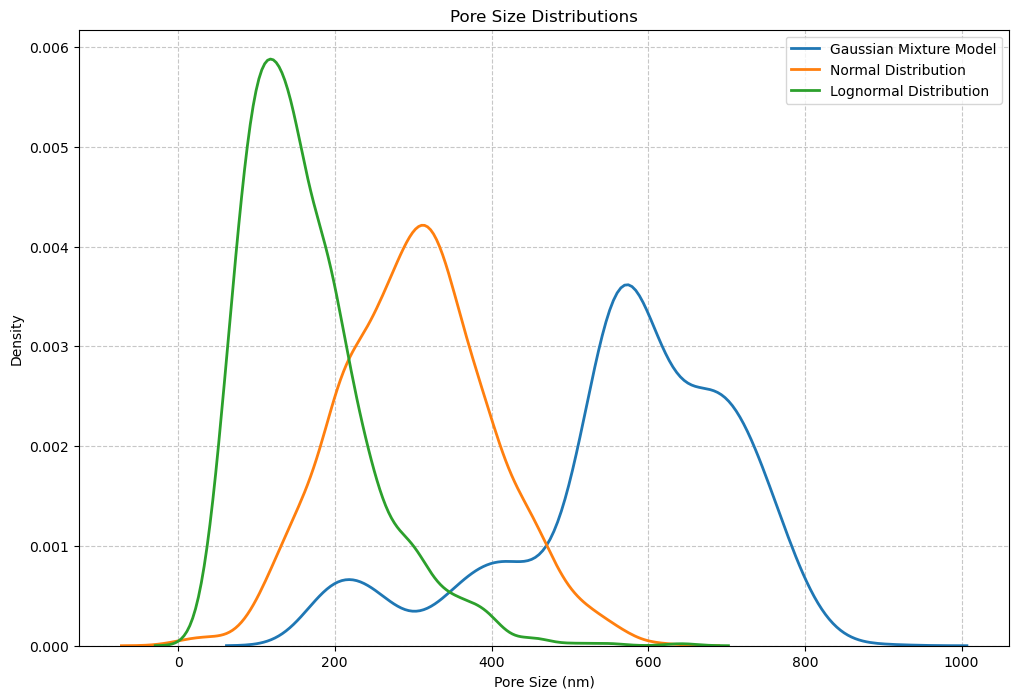

[11:27:34] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=170313;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=100795;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=259650;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=272224;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

[11:29:01] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=105856;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=934467;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=895779;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=758506;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

[11:30:38] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=173727;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=329573;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=942423;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=702878;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

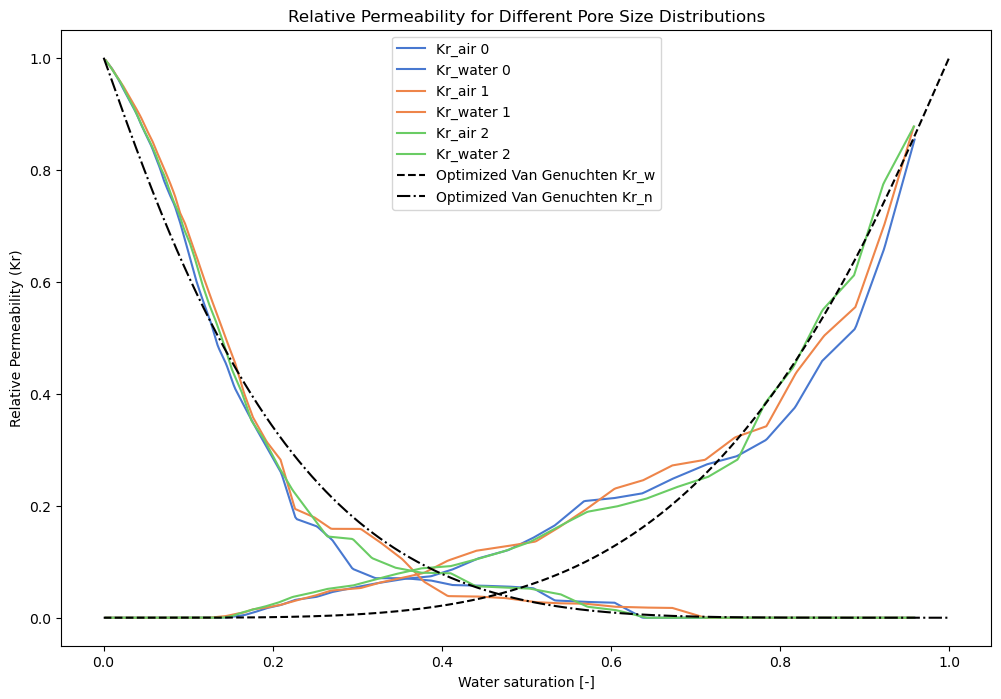

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpnm as op
import warnings
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from scipy.signal import find_peaks

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Generate new data using the fitted GMM parameters
def generate_data_from_gmm(gmm, num_samples=5000):
    log_samples, _ = gmm.sample(num_samples)
    samples = np.exp(log_samples)
    return samples.flatten()


# Function to update pore sizes in the network
def update_network_pore_sizes(pn, pore_sizes):
    while len(pore_sizes) < pn.Np:
        # Generate additional data if not enough
        pore_sizes = np.append(pore_sizes, generate_data_from_gmm(gmm, num_samples=pn.Np - len(pore_sizes)))
    pn['pore.diameter'] = pore_sizes[:pn.Np] * 1e-9  # Convert nm to meters
    pn.regenerate_models()

def generate_and_plot_pore_size_distributions(num_samples=1000):
    plt.figure(figsize=(12, 8))
    all_pore_sizes = []
    distributions = [
        ('Gaussian Mixture Model', generate_data_from_gmm(gmm, num_samples)),
        ('Normal Distribution', np.random.normal(loc=300, scale=100, size=num_samples)),
        ('Lognormal Distribution', np.random.lognormal(mean=5, sigma=0.5, size=num_samples)),
    ]
    
    for label, data in distributions:
        all_pore_sizes.append(data)
        sns.kdeplot(data, label=label, linewidth=2)

    plt.xlabel('Pore Size (nm)')
    plt.ylabel('Density')
    plt.title('Pore Size Distributions')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    return all_pore_sizes


# Van Genuchten-Mualem model functions with optimization parameters
def van_genuchten_krw(Sw, nk, b):
    return Sw**nk * (1 - (1 - Sw**b)**(1/b))**2

def van_genuchten_krn(Sw, na, b):
    return (1 - Sw)**na * (1 - Sw**(1/b))**(2*b)

# Effective saturation range
Se = np.linspace(0, 1, 500)

# Define the optimization function for Kr_water and Kr_air
def objective(params, saturation, kr_water, kr_air):
    nk, na, b = params
    krw_fit = van_genuchten_krw(saturation, nk, b)
    krn_fit = van_genuchten_krn(saturation, na, b)
    error = np.sum((kr_water - krw_fit)**2 + (kr_air - krn_fit)**2)
    return error


# Define viscosity and surface tension models
def viscosity_arrhenius(water, mu_0=1.002e-3, Ea=5000, R=8.314):
    T = water['pore.temperature']
    mu = mu_0 * np.exp(Ea / (R * T))
    return mu

def surface_tension_model(water, sigma_0=0.0756, Tc=647.096, n=1.256):
    T = water['pore.temperature']
    sigma = sigma_0 * (1 - T / Tc) ** n
    return sigma

def compute_diffusivity(diameter):
    """
    Computes the diffusivity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of diffusivities.
    """
    diameter = diameter*1e10  #the pore network unit is in meter , so we need to convert it to Amstrong
    return (k * T) / (6 * np.pi * a * diameter)

def compute_viscosity(diameter):
    """
    Computes the viscosity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of viscosities.
    """
    diffusivity = compute_diffusivity(diameter)
    return (k * T) / (6 * np.pi * diffusivity * a)


def sat_occ_update(network, nwp, wp, ip, i):
    r"""
        Calculates the saturation of each phase using the invasion
        sequence from either invasion percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        ip : IP
            invasion percolation (ran before calling this function)
        i: int
            The invasion_sequence limit for masking pores/throats that
            have already been invaded within this limit range. The
            saturation is found by adding the volume of pores and thorats
            that meet this sequence limit divided by the bulk volume.
    """
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val

# Function to perform simulation
def perform_simulation(pore_sizes):
    pn = op.network.Cubic(shape=[150, 150, 1], spacing=1e-5)
    num_pores = pn.Np
    update_network_pore_sizes(pn, pore_sizes)

    pn.add_model(propname='pore.seed', model=op.models.misc.random, element='pore', num_range=[0, 1])
    pn.add_model(propname='throat.seed', model=op.models.misc.random, element='throat', num_range=[0, 1])
    mods = op.models.collections.geometry.cubes_and_cuboids
    pn.add_model_collection(mods)
    pn.regenerate_models()

    pn['pore.volume'] = pn['pore.volume']

    f = op.models.geometry.throat_length.spheres_and_cylinders
    pn.add_model(propname='throat.length', model=f)
    f1 = op.models.geometry.pore_volume.sphere
    pn.add_model(propname='pore.volume', model=f1)
    f2 = op.models.geometry.throat_volume.cylinder
    pn.add_model(propname='throat.total_volume', model=f2)
    f3 = op.models.geometry.throat_volume.lens
    pn.add_model(propname='throat.lens_volume', model=f3)
    f4 = op.models.misc.difference
    pn.add_model(propname='throat.volume', model=f4, props=['throat.total_volume', 'throat.lens_volume'])

    # Create phases
    air = op.phase.Air(network=pn, name='air')
    air['pore.surface_tension'] = 0.072
    air['pore.contact_angle'] = 140.0
    air.add_model_collection(op.models.collections.phase.air)
    air.add_model_collection(op.models.collections.physics.basic)
    air.regenerate_models()

    water = op.phase.Water(network=pn, name='water')
    water.add_model_collection(op.models.collections.phase.water)
    water.add_model_collection(op.models.collections.physics.basic)

    # Define throat diffusivity for both air and water phases
    air['throat.diffusivity'] = 1e-9  # Example value for air
    water['throat.diffusivity'] = 1e-9  # Example value for water

    # Add the diffusive conductance model
    air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
    water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

    # Invasion percolation
    ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
    Finlets_init = pn.pores('right')
    Finlets = [Finlets_init[x] for x in range(0, len(Finlets_init), 2)]
    ip.set_inlet_BC(pores=Finlets)
    ip.run()

    flow_in = pn.pores('left')
    flow_out = pn.pores('right')

    # Multiphase conduit conductance model
    model_mp_cond = op.models.physics.multiphase.conduit_conductance
    air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
    water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

    Snwp_num = 60
    max_seq = np.max([np.max(ip['pore.invasion_sequence']), np.max(ip['throat.invasion_sequence'])])
    start = max_seq // Snwp_num
    stop = max_seq
    step = max_seq // Snwp_num
    Snwparr = []
    relperm_nwp = []
    relperm_wp = []

    for i in range(start, stop, step):
        air.regenerate_models()
        water.regenerate_models()
        sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
        Snwparr.append(sat)
        Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        relperm_nwp.append(Rate_enwp / Rate_abs_nwp)
        relperm_wp.append(Rate_ewp / Rate_abs_wp)

    return (Snwparr, relperm_nwp, relperm_wp)

# Data
# Experimental pore size distribution data
data = {
    'x': [173.1936416184971, 189.16184971098266, 194.07514450867052, 207.58670520231215, 218.64161849710982, 
          230.92485549132948, 245.66473988439304, 255.49132947976878, 283.742774566474, 311.9942196531792, 
          347.61560693641616, 364.8121387283237, 374.6387283236994, 388.15028901734104, 415.1734104046243, 
          439.73988439306356, 464.3063583815029, 488.87283236994216, 507.29768786127164, 524.4942196531791, 
          534.320809248555, 541.6907514450867, 546.6040462427745, 553.9739884393064, 560.1156069364162, 
          573.6271676300578, 578.5404624277456, 587.1387283236994, 600.650289017341, 626.4450867052022, 
          644.8699421965317, 658.3815028901734, 671.893063583815, 685.4046242774566, 702.6011560693642, 
          716.1127167630058, 728.3959537572255, 743.135838150289, 757.8757225433526, 775.0722543352601, 
          787.3554913294797, 799.6387283236994, 813.150289017341, 822.9768786127167, 836.4884393063584],
    
    'y': [0.0003567567567567567, 0.00045405405405405405, 0.000627027027027027, 0.0007351351351351351, 
          0.0005621621621621621, 0.0004216216216216216, 0.0006162162162162162, 0.000681081081081081, 
          0.00045405405405405405, 0.0006054054054054054, 0.0005297297297297297, 0.0007135135135135134, 
          0.0008324324324324324, 0.0010054054054054054, 0.0011027027027027026, 0.0011783783783783784, 
          0.001189189189189189, 0.0011567567567567568, 0.0011675675675675676, 0.0012864864864864864, 
          0.0014486486486486485, 0.0016108108108108107, 0.0017837837837837837, 0.0020324324324324326, 
          0.0021945945945945947, 0.0024108108108108106, 0.002637837837837838, 0.0028324324324324325, 
          0.0030270270270270267, 0.0031675675675675676, 0.0030378378378378376, 0.002897297297297297, 
          0.002724324324324324, 0.002518918918918919, 0.002227027027027027, 0.002054054054054054, 
          0.0018918918918918919, 0.0016216216216216215, 0.0013945945945945946, 0.0011027027027027026, 
          0.0008972972972972973, 0.000627027027027027, 0.0004432432432432432, 0.0002702702702702703, 
          0.000054054054054054054]
}
# Convert the pore size distribution to a probability density function
x = np.array(data['x'])
y = np.array(data['y'])
pdf = y / np.sum(y)

#Generate synthetic pore sizes based on the PDF
np.random.seed(0)  # For reproducibility
r = np.random.choice(x, size=1000, p=pdf)

#Identify peaks in the experimental data
peaks, _ = find_peaks(y, height=0)
peak_positions = x[peaks]
peak_heights = y[peaks]

#Fit a Gaussian Mixture Model to the data
n_components = len(peaks)
gmm = GaussianMixture(n_components=n_components, random_state=0, n_init=10, max_iter=5000)
log_r = np.log(r).reshape(-1, 1)
gmm.fit(log_r)

# Generate synthetic data
synthetic_data = generate_data_from_gmm(gmm, num_samples=1000)

# Generate and plot pore size distributions
all_pore_sizes = generate_and_plot_pore_size_distributions(num_samples=1000)
# Perform simulation for each pore size distribution
results = []
for pore_sizes in all_pore_sizes:
    results.append(perform_simulation(pore_sizes))

# Extract simulated data for optimization
saturation = 1 - np.array(results[0][0])
kr_water_sim = np.array(results[0][2]).flatten()
kr_air_sim = np.array(results[0][1]).flatten()

# Initial guesses for the parameters
initial_params = [0.5, 0.5, 1.0]

# Perform the optimization
opt_params, _ = curve_fit(lambda Sw, nk, na, b: np.hstack([van_genuchten_krw(Sw, nk, b), van_genuchten_krn(Sw, na, b)]),
                          saturation, np.hstack([kr_water_sim, kr_air_sim]), p0=initial_params)

nk_opt, na_opt, b_opt = opt_params

# Plotting relative permeabilities with optimized parameters
plt.figure(figsize=[12, 8])
palette = sns.color_palette("muted", len(results))

for idx, (Snwparr, relperm_nwp, relperm_wp) in enumerate(results):
    # Interpolation for smoother curves
    saturation = 1 - np.array(Snwparr)
    kr_air = np.array(relperm_nwp).flatten()
    kr_water = np.array(relperm_wp).flatten()

    # Define interpolating functions
    interp_func_air = interp1d(saturation, kr_air, kind='linear')
    interp_func_water = interp1d(saturation, kr_water, kind='linear')

    # Generate smooth data points
    smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
    smooth_kr_air = interp_func_air(smooth_saturation)
    smooth_kr_water = interp_func_water(smooth_saturation)

    plt.plot(smooth_saturation, smooth_kr_air, label=f'Kr_air {idx}', color=palette[idx])
    plt.plot(smooth_saturation, smooth_kr_water, label=f'Kr_water {idx}', color=palette[idx])

# Plot Van Genuchten-Mualem model with optimized parameters
plt.plot(Se, van_genuchten_krw(Se, nk_opt, b_opt), 'k--', label='Optimized Van Genuchten Kr_w')
plt.plot(Se, van_genuchten_krn(Se, na_opt, b_opt), 'k-.', label='Optimized Van Genuchten Kr_n')

plt.xlabel('Water saturation [-]')
plt.ylabel('Relative Permeability (Kr)')
plt.title('Relative Permeability for Different Pore Size Distributions')
plt.legend()
plt.show()


============== Make sure the input variables are set correctly ===============


[16:51:55] ERROR    Error loading file CMI_concrete_pore_size_data_chen_et_al_2012.csv: Data file  4092295142.py:53
                    must contain 'x' and 'y' columns.                                                              

<Figure size 1200x800 with 0 Axes>

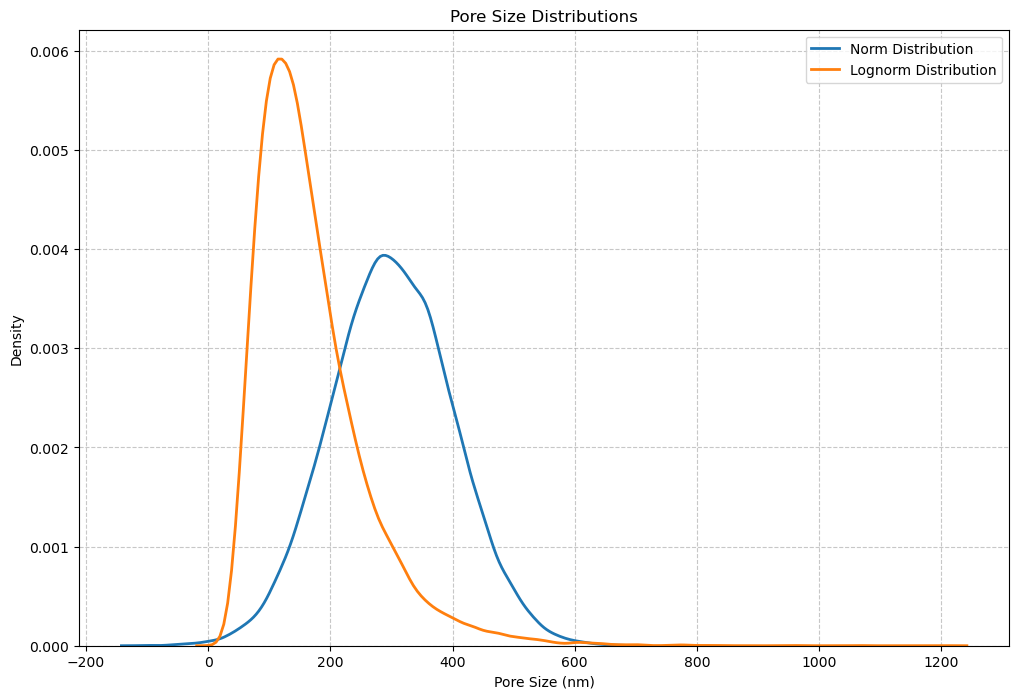

================== Initializing the files names =============================
Initial number of pores size 40000
Modified number of pores size 40000


[16:52:00] WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=766734;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=590898;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

           WARNING  throat.conduit_hydraulic_conductance was not run since the following property is ]8;id=835244;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=799051;file://c:\Anaconda\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.occupancy'                                                                    

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.mixture import GaussianMixture
from scipy.signal import find_peaks
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import os
import logging
import csv
import h5py
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

import scipy.stats as stats
import matplotlib.pyplot as plt
import openpnm as op
import porespy as ps
import warnings
from datetime import datetime
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to load data from CSV, Excel, or .dat files
def load_experimental_data(file_paths):
    data = []
    for file_path in file_paths:
        try:
            file_extension = os.path.splitext(file_path)[1].lower()
            if file_extension in ['.csv', '.dat']:
                # Detect delimiter
                with open(file_path, 'r') as f:
                    delimiter = csv.Sniffer().sniff(f.readline()).delimiter
                df = pd.read_csv(file_path, delimiter=delimiter)
            elif file_extension in ['.xls', '.xlsx']:
                df = pd.read_excel(file_path)
            else:
                raise ValueError(f"Unsupported file type: {file_extension}")
            # Remove rows containing letters in numeric columns
            df = df.apply(pd.to_numeric, errors='coerce').dropna()
            if 'y' not in df.columns or 'x' not in df.columns:
                raise ValueError("Data file must contain 'x' and 'y' columns.")
            if df.isnull().values.any():
                raise ValueError("Data contains NaN values. Please clean the data before proceeding.")
            if (df['y'] < 0).any():
                raise ValueError("Data contains negative values in 'y'. Please ensure all values are non-negative.")
            data.append((df['x'].values, df['y'].values))
        except Exception as e:
            logging.error(f"Error loading file {file_path}: {e}")
    return data

# Generate new data using the fitted GMM parameters
def generate_data_from_gmm(gmm, num_samples=1000):
    try:
        log_samples, _ = gmm.sample(num_samples)
        samples = np.exp(log_samples)
        return samples.flatten()
    except Exception as e:
        logging.error(f"Error generating data from GMM: {e}")
        return np.array([])

# Generate synthetic pore sizes based on the experimental data PDF
def generate_data_from_pdf(x, y, num_samples=1000):
    try:
        if np.sum(y) == 0:
            raise ValueError("Sum of 'y' values is zero. Cannot create a valid PDF.")
        pdf = y / np.sum(y)
        pdf = np.clip(pdf, 0, 1)  # Ensure the values remain in a valid range
        pdf /= np.sum(pdf)  # Normalize to ensure the probabilities sum to 1
        np.random.seed(0)  # For reproducibility
        return np.random.choice(x, size=num_samples, p=pdf)
    except Exception as e:
        logging.error(f"Error generating data from PDF: {e}")
        return np.array([])

# Identify peaks in data and return the number of components
def identify_peaks(y):
    try:
        peaks, _ = find_peaks(y, height=0)
        if len(peaks) == 0:
            logging.warning("No peaks found in the data. Defaulting to 1 component.")
            return 1
        return len(peaks)
    except Exception as e:
        logging.error(f"Error identifying peaks: {e}")
        return 1  # Default to 1 component if no peaks are found

# Fit Gaussian Mixture Model to data
def fit_gmm_to_data(data, n_components):
    try:
        if len(data) == 0:
            raise ValueError("Data is empty. Cannot fit GMM.")
        if np.any(data <= 0):
            logging.warning("Data contains non-positive values. Replacing non-positive values with a small positive value to avoid -inf in log.")
            data = np.where(data <= 0, 1e-10, data)  # Replace non-positive values with a small positive value
        log_r = np.log(data).reshape(-1, 1)
        gmm = GaussianMixture(n_components=n_components, random_state=0, n_init=10, max_iter=5000)
        gmm.fit(log_r)
        return gmm
    except Exception as e:
        logging.error(f"Error fitting GMM to data: {e}")
        return None

# Generate synthetic data from specified scipy stats model
def generate_data_from_scipy_model(model, num_samples=5000, **kwargs):
    try:
        if hasattr(stats, model):
            dist = getattr(stats, model)
            return dist.rvs(size=num_samples, **kwargs)
        else:
            raise ValueError(f"Unsupported model: {model}")
    except Exception as e:
        logging.error(f"Error generating data from scipy stats model '{model}': {e}")
        return np.array([])

# Generate and plot pore size distributions
def generate_and_plot_pore_size_distributions(experimental_data, scipy_models, num_samples=1000):
    plt.figure(figsize=(12, 8))
    all_pore_sizes = []
    
    # Generate data from experimental data using GMM
    for x, y in experimental_data:
        n_components = identify_peaks(y)
        generated_data = generate_data_from_pdf(x, y, num_samples)
        if len(generated_data) > 0:
            gmm = fit_gmm_to_data(generated_data, n_components)
            if gmm is not None:
                gmm_data = generate_data_from_gmm(gmm, num_samples)
                all_pore_sizes.append(gmm_data)
                sns.kdeplot(gmm_data, label='Gaussian Mixture Model', linewidth=2)
    
    # Generate data from specified scipy stats models
    for model in scipy_models:
        data = generate_data_from_scipy_model(model['name'], num_samples=num_samples, **model['params'])
        if len(data) > 0:
            all_pore_sizes.append(data)
            sns.kdeplot(data, label=f"{model['name'].capitalize()} Distribution", linewidth=2)

    plt.xlabel('Pore Size (nm)')
    plt.ylabel('Density')
    plt.title('Pore Size Distributions')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    return all_pore_sizes

# Function to update pore sizes in the network
def update_network_pore_sizes(pn, pore_sizes):
    while len(pore_sizes) < pn.Np:
        # Generate additional data if not enough
        pore_sizes = np.append(pore_sizes, generate_data_from_gmm(gmm, num_samples=pn.Np - len(pore_sizes)))
    pn['pore.diameter'] = pore_sizes[:pn.Np] * 1e-9  # Convert nm to meters
    pn.regenerate_models()
    
# Van Genuchten-Mualem model functions with optimization parameters
def van_genuchten_krw(Sw, nk, b):
    return Sw**nk * (1 - (1 - Sw**b)**(1/b))**2

def van_genuchten_krn(Sw, na, b):
    return (1 - Sw)**na * (1 - Sw**(1/b))**(2*b)

# Effective saturation range
Se = np.linspace(0, 1, 500)

# Define the optimization function for Kr_water and Kr_air
def objective(params, saturation, kr_water, kr_air):
    nk, na, b = params
    krw_fit = van_genuchten_krw(saturation, nk, b)
    krn_fit = van_genuchten_krn(saturation, na, b)
    error = np.sum((kr_water - krw_fit)**2 + (kr_air - krn_fit)**2)
    return error


# Define viscosity and surface tension models
def viscosity_arrhenius(water, mu_0=1.002e-3, Ea=5000, R=8.314):
    T = water['pore.temperature']
    mu = mu_0 * np.exp(Ea / (R * T))
    return mu

def surface_tension_model(water, sigma_0=0.0756, Tc=647.096, n=1.256):
    T = water['pore.temperature']
    sigma = sigma_0 * (1 - T / Tc) ** n
    return sigma

def compute_diffusivity(diameter):
    """
    Computes the diffusivity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of diffusivities.
    """
    diameter = diameter*1e10  #the pore network unit is in meter , so we need to convert it to Amstrong
    return (k * T) / (6 * np.pi * a * diameter)

def compute_viscosity(diameter):
    """
    Computes the viscosity using the Einstein-Stokes equation.
    
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    
    Returns:
    Array of viscosities.
    """
    diffusivity = compute_diffusivity(diameter)
    return (k * T) / (6 * np.pi * diffusivity * a)

def sat_occ_update(network, nwp, wp, ip, i):
    r"""
        Calculates the saturation of each phase using the invasion
        sequence from either invasion percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        ip : IP
            invasion percolation (ran before calling this function)
        i: int
            The invasion_sequence limit for masking pores/throats that
            have already been invaded within this limit range. The
            saturation is found by adding the volume of pores and thorats
            that meet this sequence limit divided by the bulk volume.
    """
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val

def create_pore_network(pore_sizes, geometry_shape='cubic', sample_shape=[200, 200, 1]):
    print("Initial number of pores size",len(pore_sizes))
    if len(pore_sizes) == 0:
        raise ValueError("Pore size data is empty. Cannot create pore network.")

    network_types = {
        'cubic': op.network.Cubic,
        'voronoi': op.network.Voronoi,
        'delaunay': op.network.Delaunay,
        'voronoidual': op.network.DelaunayVoronoiDual
    }

    if geometry_shape.lower() not in network_types:
        raise ValueError(f"Unsupported geometry shape: {geometry_shape}. Must be one of {list(network_types.keys())}.")

    NetworkClass = network_types[geometry_shape.lower()]

    if geometry_shape.lower() in ['voronoi', 'delaunay', 'voronoidual']:
        points = np.random.rand(len(pore_sizes), 3)  # Generate random points in 3D
        pn = NetworkClass(shape=sample_shape,points=points)
    else:
        pn = NetworkClass(shape=sample_shape, spacing=1e-5)
        
        pn.add_model(propname='pore.seed', model=op.models.misc.random, element='pore', num_range=[0, 1])
        pn.add_model(propname='throat.seed', model=op.models.misc.random, element='throat', num_range=[0, 1])
        mods = op.models.collections.geometry.cubes_and_cuboids
        pn.add_model_collection(mods)
        pn.regenerate_models()

        if pn.Np > len(pore_sizes):
            # If cubic sample has more pores, extend pore sizes by random choice
            pore_sizes = np.random.choice(pore_sizes, size=pn.Np, replace=True)
        elif pn.Np < len(pore_sizes):
            # If cubic sample has fewer pores, resample pore sizes
            pore_sizes = np.random.choice(pore_sizes, size=pn.Np, replace=False)
    print("Modified number of pores size", len(pore_sizes))
    pn['pore.diameter'] = np.array(pore_sizes) * 1e-9  # Convert nm to meters
    pn.regenerate_models()

    return pn

#Function to perform simulation
def perform_relative_permeability_simulation_psd(pore_sizes):
    pn = op.network.Cubic(shape=[200, 200, 1], spacing=1e-5)
    
    num_pores = pn.Np
    update_network_pore_sizes(pn, pore_sizes)
    pn.add_model(propname='pore.seed', model=op.models.misc.random, element='pore', num_range=[0, 1])
    pn.add_model(propname='throat.seed', model=op.models.misc.random, element='throat', num_range=[0, 1])
    mods = op.models.collections.geometry.cubes_and_cuboids
    pn.add_model_collection(mods)
   
    pn.regenerate_models()
    pn['pore.volume'] = pn['pore.volume']
    f = op.models.geometry.throat_length.spheres_and_cylinders
    pn.add_model(propname='throat.length', model=f)
    f1 = op.models.geometry.pore_volume.sphere
    pn.add_model(propname='pore.volume', model=f1)
    f2 = op.models.geometry.throat_volume.cylinder
    pn.add_model(propname='throat.total_volume', model=f2)
    f3 = op.models.geometry.throat_volume.lens
    pn.add_model(propname='throat.lens_volume', model=f3)
    f4 = op.models.misc.difference
    pn.add_model(propname='throat.volume', model=f4, props=['throat.total_volume', 'throat.lens_volume'])

    # Create phases
    air = op.phase.Air(network=pn, name='air')
    air['pore.surface_tension'] = 0.072
    air['pore.contact_angle'] = 140.0
    air.add_model_collection(op.models.collections.phase.air)
    air.add_model_collection(op.models.collections.physics.basic)
    air.regenerate_models()

    water = op.phase.Water(network=pn, name='water')
    water.add_model_collection(op.models.collections.phase.water)
    water.add_model_collection(op.models.collections.physics.basic)

    # Define throat diffusivity for both air and water phases
    air['throat.diffusivity'] = 1e-9  # Example value for air
    water['throat.diffusivity'] = 1e-9  # Example value for water

    # Add the diffusive conductance model
    air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
    water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

    # Invasion percolation
    ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
    Finlets_init = pn.pores('right')
    Finlets = [Finlets_init[x] for x in range(0, len(Finlets_init), 2)]
    ip.set_inlet_BC(pores=Finlets)
    ip.run()

    flow_in = pn.pores('left')
    flow_out = pn.pores('right')

    # Multiphase conduit conductance model
    model_mp_cond = op.models.physics.multiphase.conduit_conductance
    air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
    water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

    Snwp_num = 60
    max_seq = np.max([np.max(ip['pore.invasion_sequence']), np.max(ip['throat.invasion_sequence'])])
    start = max_seq // Snwp_num
    stop = max_seq
    step = max_seq // Snwp_num
    Snwparr = [] 
    relperm_nwp = []
    relperm_wp = []

    for i in range(start, stop, step):
        air.regenerate_models()
        water.regenerate_models()
        sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
        Snwparr.append(sat)
        Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        relperm_nwp.append(Rate_enwp / Rate_abs_nwp)
        relperm_wp.append(Rate_ewp / Rate_abs_wp)

    return (Snwparr, relperm_nwp, relperm_wp)

def perform_relative_permeability_simulation_psd_to_pn(pn):
    pn['pore.volume'] = pn['pore.volume']
    f = op.models.geometry.throat_length.spheres_and_cylinders
    pn.add_model(propname='throat.length', model=f)
    f1 = op.models.geometry.pore_volume.sphere
    pn.add_model(propname='pore.volume', model=f1)
    f2 = op.models.geometry.throat_volume.cylinder
    pn.add_model(propname='throat.total_volume', model=f2)
    f3 = op.models.geometry.throat_volume.lens
    pn.add_model(propname='throat.lens_volume', model=f3)
    f4 = op.models.misc.difference
    pn.add_model(propname='throat.volume', model=f4, props=['throat.total_volume', 'throat.lens_volume'])
    
    # Create phases
    air = op.phase.Air(network=pn, name='air')
    air['pore.surface_tension'] = 0.072
    air['pore.contact_angle'] = 140.0
    air.add_model_collection(op.models.collections.phase.air)
    air.add_model_collection(op.models.collections.physics.basic)
    air.regenerate_models()

    water = op.phase.Water(network=pn, name='water')
    water.add_model_collection(op.models.collections.phase.water)
    water.add_model_collection(op.models.collections.physics.basic)

    # Define throat diffusivity for both air and water phases
    air['throat.diffusivity'] = 1e-9  # Example value for air
    water['throat.diffusivity'] = 1e-9  # Example value for water

    # Add the diffusive conductance model
    air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
    water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

    # Invasion percolation
    ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
    Finlets_init = pn.pores('right')
    Finlets = [Finlets_init[x] for x in range(0, len(Finlets_init), 2)]
    ip.set_inlet_BC(pores=Finlets)
    ip.run()

    flow_in = pn.pores('left')
    flow_out = pn.pores('right')

    # Multiphase conduit conductance model
    model_mp_cond = op.models.physics.multiphase.conduit_conductance
    air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
    water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance', throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

    Snwp_num = 60
    max_seq = np.max([np.max(ip['pore.invasion_sequence']), np.max(ip['throat.invasion_sequence'])])
    start = max_seq // Snwp_num
    stop = max_seq
    step = max_seq // Snwp_num
    Snwparr = []
    relperm_nwp = []
    relperm_wp = []

    for i in range(start, stop, step):
        air.regenerate_models()
        water.regenerate_models()
        sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
        Snwparr.append(sat)
        Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.hydraulic_conductance')
        Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance='throat.conduit_hydraulic_conductance')
        relperm_nwp.append(Rate_enwp / Rate_abs_nwp)
        relperm_wp.append(Rate_ewp / Rate_abs_wp)

    return (Snwparr, relperm_nwp, relperm_wp)

# Function to initialize the directory and files for storing the results of the study
def initialize_study_directory(studyname, study_variable):
    
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    results_directory = f"{studyname}_simulation_results_{current_time}"
    os.makedirs(results_directory, exist_ok=True)

    # File paths for storing results
    tortuosity_csv_path = os.path.join(results_directory, "tortuosity_results.csv")
    relperm_csv_path = os.path.join(results_directory, "relative_permeability_results.csv")
    final_csv_path = os.path.join(results_directory, "combined_results_for_AI.csv")

    # Write headers to CSV files if they don't exist
    if not os.path.exists(tortuosity_csv_path):
        with open(tortuosity_csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([str(study_variable), "Tortuosity", "Formation Factor", "Original Porosity", "Effective Porosity"])

    if not os.path.exists(relperm_csv_path):
        with open(relperm_csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([str(study_variable), "Direction", "Saturation", "Kr_air", "Kr_water"])

    if not os.path.exists(final_csv_path):
        with open(final_csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([str(study_variable), "Direction", "Saturation", "Kr_air", "Kr_water", "Tortuosity", "Formation Factor", "Original Porosity", "Effective Porosity"])

    #return results_directory, tortuosity_csv_path, relperm_csv_path, final_csv_path

# Main
if __name__ == "__main__":

    studyname ="impact_experimental_psd_measurements"
    study_variable ="psd_origin"
    initialize_study_directory(studyname, study_variable)

    print("============== Make sure the input variables are set correctly ===============")
    #Load experimental data from CSV, Excel, or .dat files
    file_paths = ["CMI_concrete_pore_size_data_chen_et_al_2012.csv"]  # Add paths as needed
    experimental_data = load_experimental_data(file_paths)

    #Define scipy stats models
    scipy_models = [
        {'name': 'norm', 'params': {'loc': 300, 'scale': 100}},
        {'name': 'lognorm', 'params': {'s': 0.5, 'scale': np.exp(5)}},
        # Add more models as needed
    ]
    # Generate and plot pore size distributions
    plt.figure(figsize=(12, 8))  # Move figure creation outside the loop to improve performance
    all_pore_sizes = generate_and_plot_pore_size_distributions(experimental_data, scipy_models, num_samples=40000)
    
    ## Perform simulations
    print("================== Initializing the files names =============================")
    results = []
    
    for pore_sizes in all_pore_sizes:
        geometry_shape = 'cubic'
        pn = create_pore_network(pore_sizes, geometry_shape=geometry_shape, sample_shape=[200, 200, 1])
        results.append(perform_relative_permeability_simulation_psd_to_pn(pn))


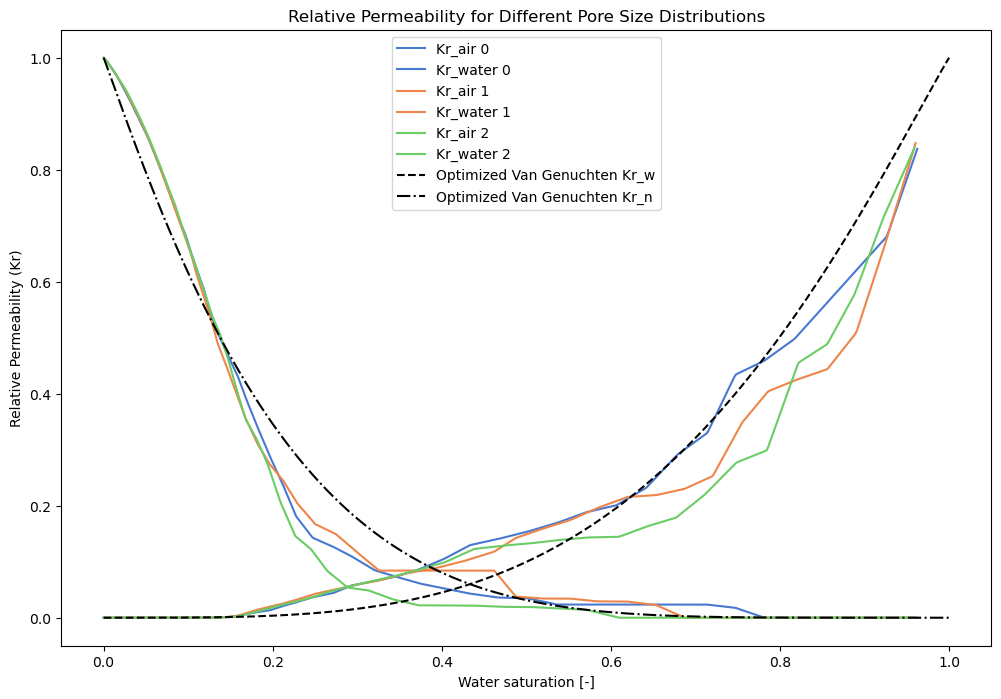

In [16]:
# Extract simulated data for optimization
saturation = 1 - np.array(results[0][0])
kr_water_sim = np.array(results[0][2]).flatten()
kr_air_sim = np.array(results[0][1]).flatten()

# Initial guesses for the parameters
initial_params = [0.5, 0.5, 1.0]

# Perform the optimization
opt_params, _ = curve_fit(lambda Sw, nk, na, b: np.hstack([van_genuchten_krw(Sw, nk, b), van_genuchten_krn(Sw, na, b)]),
                          saturation, np.hstack([kr_water_sim, kr_air_sim]), p0=initial_params)

nk_opt, na_opt, b_opt = opt_params

# Plotting relative permeabilities with optimized parameters
plt.figure(figsize=[12, 8])
palette = sns.color_palette("muted", len(results))

for idx, (Snwparr, relperm_nwp, relperm_wp) in enumerate(results):
    # Interpolation for smoother curves
    saturation = 1 - np.array(Snwparr)
    kr_air = np.array(relperm_nwp).flatten()
    kr_water = np.array(relperm_wp).flatten()

    # Define interpolating functions
    interp_func_air = interp1d(saturation, kr_air, kind='linear')
    interp_func_water = interp1d(saturation, kr_water, kind='linear')

    # Generate smooth data points
    smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
    smooth_kr_air = interp_func_air(smooth_saturation)
    smooth_kr_water = interp_func_water(smooth_saturation)

    plt.plot(smooth_saturation, smooth_kr_air, label=f'Kr_air {idx}', color=palette[idx])
    plt.plot(smooth_saturation, smooth_kr_water, label=f'Kr_water {idx}', color=palette[idx])

# Plot Van Genuchten-Mualem model with optimized parameters
plt.plot(Se, van_genuchten_krw(Se, nk_opt, b_opt), 'k--', label='Optimized Van Genuchten Kr_w')
plt.plot(Se, van_genuchten_krn(Se, na_opt, b_opt), 'k-.', label='Optimized Van Genuchten Kr_n')

plt.xlabel('Water saturation [-]')
plt.ylabel('Relative Permeability (Kr)')
plt.title('Relative Permeability for Different Pore Size Distributions')
plt.legend()
plt.show()

## Simulation from experimental acquired image stored in Digital Rock portal

In [ ]:
import os
import numpy as np

def download_image(filename, url):
    download_command = f'wget {url} -O {filename}'
    try:
        subprocess.run(download_command.split(' '))
    except FileNotFoundError:
        raise InterruptedError(f'wget was not found. Please make sure it is installed on your system.')
    return

def load_image_to_3d(filename, data_type, voxelsx=None, voxelsy=None):
    """
    Loads a raw image from the specified path or URL, reshapes it into 3D based on inferred dimensions.
    Assumes a cubic image by default if no dimensions are provided.

    Parameters:
    path (str): Directory where the image will be saved.
    name (str): Name of the image file.
    url (str): URL to download the image if not already present.
    data_type (str): Data type for reading the image file (e.g., '<i1' for 1-byte signed integer).
    voxel_size (float): The size of each voxel in meters.
    voxelsx (int, optional): Known voxel count along the x-dimension. If not provided, assumes cubic.
    voxelsy (int, optional): Known voxel count along the y-dimension. If not provided, assumes cubic.

    Returns:
    im (numpy.ndarray): The reshaped 3D image.
    (voxelsx, voxelsy, voxelsz) (tuple of int): The inferred voxel dimensions.
    """
    # Ensure the directory exists

    # Load the raw image data
    image_data = np.fromfile(filename, dtype=data_type)
    
    # Total number of voxels
    total_voxels = image_data.size
    
    # If no dimensions are provided, assume the image is cubic
    if voxelsx is None and voxelsy is None:
        # Assuming a cubic image, calculate the side length
        voxelsx = int(round(total_voxels ** (1/3)))
        voxelsy = voxelsx
        voxelsz = voxelsx
    elif voxelsx is not None and voxelsy is not None:
        # If both voxelsx and voxelsy are provided, infer voxelsz
        voxelsz = total_voxels // (voxelsx * voxelsy)
        
        if total_voxels != voxelsx * voxelsy * voxelsz:
            raise ValueError("The inferred dimensions do not match the total number of voxels.")
    elif voxelsx is not None and voxelsy is None:
        # If only voxelsx is provided, assume a cubic y-dimension and infer z-dimension
        voxelsy = voxelsx
        voxelsz = total_voxels // (voxelsx * voxelsy)
        
        if total_voxels != voxelsx * voxelsy * voxelsz:
            raise ValueError("The inferred dimensions do not match the total number of voxels.")
    else:
        raise ValueError("You must provide at least one dimension (voxelsx) to infer the others if the image is not cubic.")
    
    # Reshape the image into the inferred 3D dimensions
    im = np.reshape(image_data, (voxelsx, voxelsy, voxelsz))
    
    # Return the reshaped image and its dimensions
    return im, (voxelsx, voxelsy, voxelsz)


In [ ]:
import requests
import imageio
from io import BytesIO

# Define the URL of the image
url = "https://www.digitalrocksportal.org/projects/317/sample/407/"
im = imageio.volread(url) 


AttributeError: 'SeekableFileObject' object has no attribute 'readline'

In [ ]:
# Call the plot function
save_dir= 'rock_sample_leopard'
plot_relative_permeability(results,pn, im, save_dir)

NameError: name 'plot_relative_permeability' is not defined

In [ ]:

## Drainage simulations
drn = op.algorithms.Drainage(network=pn, phase=water)
drn.set_inlet_BC(pn.pores('left'))
drn.run()

water['pore.occupancy'] = drn['pore.invasion_pressure'] < 10000
water['throat.occupancy'] = drn['throat.invasion_pressure'] < 10000
air['pore.occupancy'] = 1 - water['pore.occupancy']
air['throat.occupancy'] = 1 - water['throat.occupancy']


diff_in = pn.pores('left')
diff_out = pn.pores('right')

## Define multiphase conductance
model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

## Calculate the relative diffusivity
Snwparr = []
reldiff_nwp = []
reldiff_wp = []
for Pc in np.unique(drn['pore.invasion_pressure']):
    water['pore.occupancy'] = drn['pore.invasion_pressure'] < Pc
    water['throat.occupancy'] = drn['throat.invasion_pressure'] < Pc
    air['pore.occupancy'] = 1 - water['pore.occupancy']
    air['throat.occupancy'] = 1 - water['throat.occupancy']
    air.regenerate_models()
    water.regenerate_models()
    sat_point = sat_update_diffusivity(pn, water, air)
    Snwparr.append(sat_point)
    Rate_single_nwp = Rate_calc_diffusivity(pn, air, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
    Rate_single_wp = Rate_calc_diffusivity(pn, water, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
    Rate_mult_nwp = Rate_calc_diffusivity(pn, air, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
    Rate_mult_wp = Rate_calc_diffusivity(pn, water, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
    reldiff_nwp.append(Rate_mult_nwp/Rate_single_nwp)
    reldiff_wp.append(Rate_mult_wp/Rate_single_wp)
    
## Calculate the relative permeability
plt.figure(figsize=[6,5])
plt.plot(Snwparr, reldiff_nwp, '*-', label='Dr_nwp')
plt.plot(Snwparr, reldiff_wp, 'o-', label='Dr_wp')
plt.xlabel('Snwp')
plt.ylabel('Dr')
plt.title('Relative Diffusivity in x direction')
plt.legend()

Reshaped 3D image has dimensions: (1000, 1000, 1000)
0.353452


0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1718 [00:00<?, ?it/s]


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Network at 0x2af44eed0>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  throat.conns                                                  2034 / 2034
  3  pore.coords                                                   1718 / 1718
  4  pore.region_label                                             1718 / 1718
  5  pore.phase                                                    1718 / 1718
  6  throat.phases                                                 2034 / 2034
  7  pore.region_volume                                            1718 / 1718
  8  pore.equivalent_diameter                                      1718 / 1718
  9  pore.local_peak                                               1718 / 1718
 10 

[18:17:35] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=625969;file:///Users/justinkinda/Dropbox/ResarchcColab/Tulio_Farid/OpenPNM/openpnm/core/_models.py\_models.py]8;;\:]8;id=684225;file:///Users/justinkinda/Dropbox/ResarchcColab/Tulio_Farid/OpenPNM/openpnm/core/_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

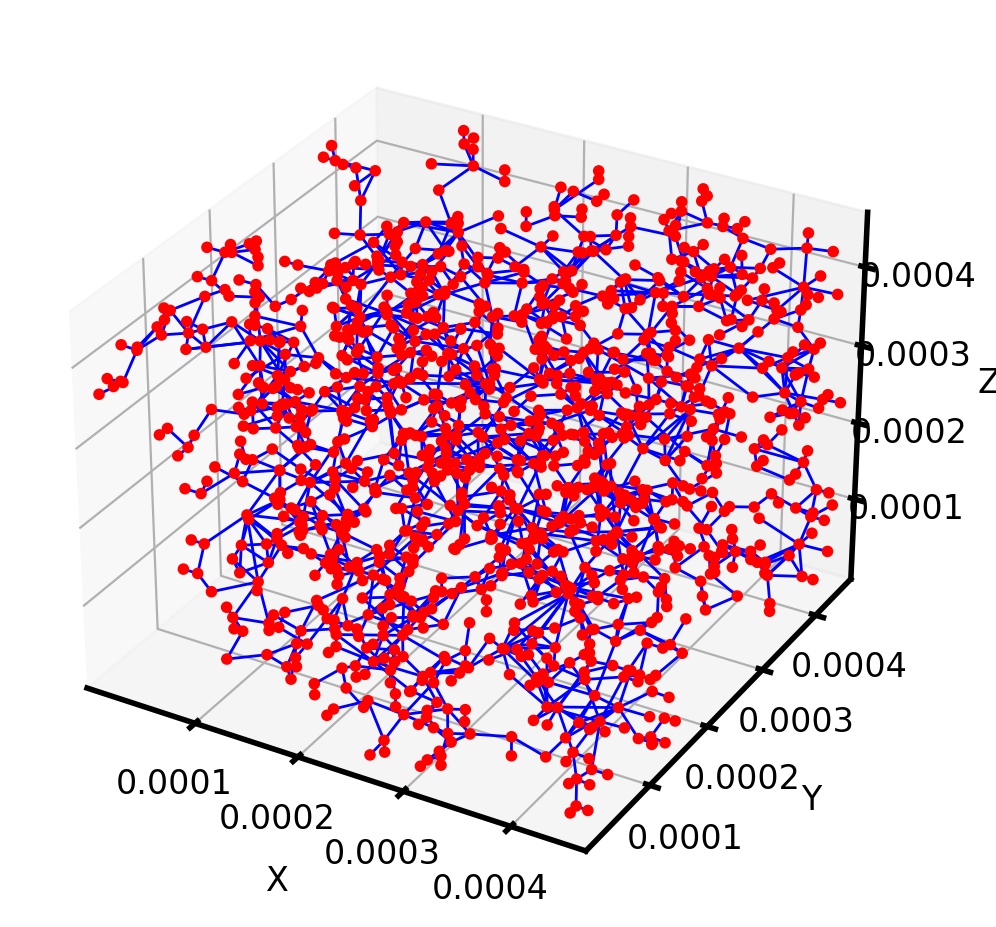

In [ ]:
import subprocess
import os
import numpy as np
import openpnm as op
import porespy as ps
import h5py  # if there was error importing, please install the h5py package
import importlib
import warnings
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from scipy.interpolate import interp1d
import time
import tensorflow as tf
import imageio

ps.visualization.set_mpl_style()
warnings.filterwarnings("ignore")

## Create network from the image 
# Fetch the image from Digital Rock portal

path = 'rock_sample_Leopard'
name = 'image_Leopard.raw'
url = 'https://www.digitalrocksportal.org/projects/317/images/223481/download/'

data_type = '<i1'  # 1-byte signed integer
voxel_size = 2.25e-6  # Voxel size in meters

# Assume cubic image
image, dimensions = load_image_to_3d(path, name, url, data_type, voxel_size)

print(f"Reshaped 3D image has dimensions: {dimensions}")

### Identify pore space and solid space
# pore space must be labeled as True and solid phase as False
pore_space = im == 0 # sometimes this may be 255 or some other value depending on the source of the image
im[pore_space] = True
im[~pore_space] = False
print(ps.metrics.porosity(im))

im = im[:400,:400,:400]


### Reduce the size of the image to be more manageable

""" 
coords = net_drp ['pore.coords']
conns = net_drp['throat.conns']
pn = op.network.Network(coords=coords, conns=conns)
print(pn)
"""

from pprint import pprint
mods = op.models.collections.geometry.spheres_and_cylinders
#pprint(mods)
pn.add_model_collection(mods)
pn.regenerate_models()
print(pn)

"""
### Create a pore network model from the image
snow = ps.networks.snow2(im, boundary_width=[3,3,3], parallelization=None, voxel_size = voxel_size)
regions = snow.regions
net = snow.network
## uncomment to Compute diffusive size factor if needed and assign it to the network
""" 

conns = net['throat.conns']
g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
net['throat.diffusive_size_factor'] = g_FD
"""
#pn1 = op.io.network_from_porespy(net)
## Create networ from porespy segmented image

pn = op.io.network_from_porespy(net)
mods = op.models.collections.geometry.cubes_and_cuboids
#pprint(mods)
pn.add_model_collection(mods)
pn['pore.diameter'] = pn['pore.equivalent_diameter']
pn['throat.diameter'] = pn['throat.inscribed_diameter']
pn['throat.spacing'] = pn['throat.total_length']
pn.regenerate_models()
print(pn)


pn.add_model(propname='throat.hydraulic_size_factors',
             model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
pn.add_model(propname='throat.diffusive_size_factors',
             model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
  

pn.regenerate_models()

## Check network health
h = op.utils.check_network_health(pn)
print(h)

## remove disconnected pores from the network
op.topotools.trim(network=pn, pores=h['disconnected_pores'])
h = op.utils.check_network_health(pn)
print(h)
## Export to Salome
op.io.network_to_salome(pn,filename='salome/image_Leopard')

ax = op.visualization.plot_connections(pn)
ax = op.visualization.plot_coordinates(pn, ax=ax)

#pn.regenerate_models()

pn.add_model(propname='pore.cluster_number',
             model=op.models.network.cluster_number)
pn.add_model(propname='pore.cluster_size',
             model=op.models.network.cluster_size)
print(pn)

print('pore diameter cluster=',pn['pore.cluster_number'])
print("==================================================")
print('pore cluster size=', pn['pore.cluster_size'])

###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Ps = pn['pore.cluster_size'] < 1290
op.topotools.trim(network=pn, pores=Ps)
#ax = op.visualization.plot_tutorial(pn, font_size=8)

###================xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

k = 1.38e-23  # Boltzmann constant in J/K
T = 300  # Temperature in K
a = 1.52e-10  # Radius of water molecule in meters


# Define viscosity and surface tension models
def viscosity_arrhenius(water, mu_0=1.002e-3, Ea=5000, R=8.314):
    T = water['pore.temperature']
    mu = mu_0 * np.exp(Ea / (R * T))
    return mu

def surface_tension_model(water, sigma_0=0.0756, Tc=647.096, n=1.256):
    T = water['pore.temperature']
    sigma = sigma_0 * (1 - T / Tc) ** n
    return sigma

"""
def compute_diffusivity(diameter):
    """
    Computes the diffusivity using the Einstein-Stokes equation.
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    Returns:
    Array of diffusivities.
    """
    
    diameter = diameter*1e10  #the pore network unit is in meter , so we need to convert it to Amstrong
    return (k * T) / (6 * np.pi * a * diameter)

def compute_viscosity(diameter):
    
    """
    Computes the viscosity using the Einstein-Stokes equation.
    Parameters:
    diameter (array): Array of pore or throat diameters in meters.
    Returns:
    Array of viscosities.
    """
    
    diffusivity = compute_diffusivity(diameter)
    return (k * T) / (6 * np.pi * diffusivity * a)

air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 180.0
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()
water = op.phase.Water(network=pn,name='water')
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water.regenerate_models()
#pn = ps.networks.label_boundaries(net,labels=[['left', 'right'],[ 'bottom','top']], tol=1e-9)
# Compute diffusivity and viscosity
pore_diffusivity = compute_diffusivity(pn['pore.diameter'])
pore_viscosity = compute_viscosity(pn['pore.diameter'])
throat_diffusivity = compute_diffusivity(pn['throat.diameter'])
throat_viscosity = compute_viscosity(pn['throat.diameter'])
# Assign diffusivity and viscosity
pn['pore.diffusivity'] = pore_diffusivity
pn['pore.viscosity'] = pore_viscosity
pn['throat.diffusivity'] = throat_diffusivity
pn['throat.viscosity'] = throat_viscosity

air['throat.diffusivity'] = throat_diffusivity # 1e-9 #pn['throat.diffusivity']
water['throat.diffusivity'] = throat_diffusivity #pn['throat.diffusivity']

# Assign viscosity using the Arrhenius model
water.add_model(propname='pore.viscosity', model=viscosity_arrhenius)

# Add the custom surface tension model to the water phase
water.add_model(propname='pore.surface_tension', model=surface_tension_model)

# Add the diffusive conductance model
air.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)
water.add_model(propname='throat.diffusive_conductance', model=op.models.physics.diffusive_conductance.ordinary_diffusion)

air.regenerate_models()
water.regenerate_models()

def sat_update_diffusivity(network, nwp, wp):
        
        """
        Calculates the saturation of each phase using occupancy information from ordinary percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        """
    pore_mask = nwp["pore.occupancy"] == 1
    throat_mask = nwp["throat.occupancy"] == 1
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    return sat

def Rate_calc_diffusivity(network, phase, inlet, outlet, conductance):
        phase.regenerate_models()
        Fd = op.algorithms.FickianDiffusion(network=network, phase=phase)
        Fd.settings._update({'conductance' : conductance})
        Fd.set_value_BC(pores=inlet, values=1)
        Fd.set_value_BC(pores=outlet, values=0)
        Fd.run()
        val = np.abs(Fd.rate(pores=inlet, mode='group'))
        return val
    
model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_diffusive_conductance',
              throat_conductance='throat.diffusive_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_diffusive_conductance',
              throat_conductance='throat.diffusive_conductance', mode='medium', regen_mode='deferred')

Snwp_num=100

# Boundary conditions for each direction
directions = {
    'x': ('xmin', 'xmax'),
    'y': ('ymin', 'ymax'),
    'z': ('zmin', 'zmax')
}

# Dictionary to store simulation results for each direction
results = {'saturation': {}, 'Dr_air': {}, 'Dr_water': {}}

# Run simulations for each direction
for direction, (inlet, outlet) in directions.items():
    ## Drainage simulations
    drn = op.algorithms.Drainage(network=pn, phase=water)
    drn.set_inlet_BC(pn.pores(inlet))
    drn.run()

    water['pore.occupancy'] = drn['pore.invasion_pressure'] < 10000
    water['throat.occupancy'] = drn['throat.invasion_pressure'] < 10000
    air['pore.occupancy'] = 1 - water['pore.occupancy']
    air['throat.occupancy'] = 1 - water['throat.occupancy']
        
    diff_in = pn.pores(inlet)
    diff_out = pn.pores(outlet)
    ## Calculate the relative diffusivity
    Snwparr = []
    reldiff_nwp = []
    reldiff_wp = []
    for Pc in np.unique(drn['pore.invasion_pressure']):
        water['pore.occupancy'] = drn['pore.invasion_pressure'] < Pc
        water['throat.occupancy'] = drn['throat.invasion_pressure'] < Pc
        air['pore.occupancy'] = 1 - water['pore.occupancy']
        air['throat.occupancy'] = 1 - water['throat.occupancy']
        air.regenerate_models()
        water.regenerate_models()
        sat_point = sat_update_diffusivity(pn, water, air)
        Snwparr.append(sat_point)
        Rate_single_nwp = Rate_calc_diffusivity(pn, air, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
        Rate_single_wp = Rate_calc_diffusivity(pn, water, diff_in, diff_out, conductance = 'throat.diffusive_conductance')
        Rate_mult_nwp = Rate_calc_diffusivity(pn, air, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
        Rate_mult_wp = Rate_calc_diffusivity(pn, water, diff_in, diff_out, conductance = 'throat.conduit_diffusive_conductance')
        reldiff_nwp.append(Rate_mult_nwp/Rate_single_nwp)
        reldiff_wp.append(Rate_mult_wp/Rate_single_wp)
        
        #Convert results to numpy arrays
        results['saturation'][direction] = 1 - np.array(Snwparr)
        results['Dr_air'][direction] = np.array(reldiff_nwp).flatten()
        results['Dr_water'][direction] = np.array(reldiff_wp).flatten()

        saturation = 1-np.asarray(Snwparr)
        Dr_air = np.array(reldiff_nwp).flatten()
        Dr_water = np.array(reldiff_wp).flatten()
        # Define interpolating functions
        interp_func_air = interp1d(saturation, Dr_air, kind='linear')
        interp_func_water = interp1d(saturation, Dr_water, kind='linear')

        # Generate smooth data points
        smooth_saturation = np.linspace(saturation.min(), saturation.max(), 500)
        smooth_Dr_air = interp_func_air(smooth_saturation)
        smooth_Dr_water = interp_func_water(smooth_saturation)




In [ ]:
plot_relative_diffusivity(results, save_dir)

Relative permeability plot saved at rock_sample_leopard/relative_diffusivity_plot.png
